<a href="https://colab.research.google.com/github/ms624atyale/BerenstainBears_4Research/blob/main/BerenstainBears_Final9Copies_Word2Vec_NLP_Freq_Plotting_13SEP24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##🐹 🐾 🐟 This script is based on [**Prof. Hosung Nam's github (hsnam95)**](https://github.com/hsnam95)

### 🐣 🐥 **Tokenization**

In [1]:
#!pip install nltk is a command to install the NLTK library. The installation is a one-time process.
!pip install nltk

#'import nltk' is a statement to make the NLTK library available for use in your Python code. The import statement is used in each script or notebook where you want to utilize NLTK functionality.
import nltk

In [2]:
! git clone https://github.com/ms624atyale/Ref_Scripts4Research

Cloning into 'Ref_Scripts4Research'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 104 (delta 59), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (104/104), 6.42 MiB | 6.48 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [3]:
import pandas as pd

# Define the file path to your CSV file
file_path = "/content/Ref_Scripts4Research/BerenstainBears/BerenstainBears_First9Copies_BodyOnly.csv"

# Load the CSV file into a pandas DataFrame
try:
    df = pd.read_csv(file_path)

    # Print the list of columns in the CSV file
    print("List of columns:", df.columns.tolist())

except FileNotFoundError:
    print(f"Error: The file at '{file_path}' was not found.")
except pd.errors.EmptyDataError:
    print("Error: The file is empty.")
except pd.errors.ParserError:
    print("Error: The file could not be parsed.")

List of columns: ['text_column']


#**🐣🐣 <font color = 'green'>Word2Vec (Frequently used word pairs)**

#**<font color = 'green'> Use the following script for semantically related word pairs by the Word2Vec class.**

In [4]:
import pandas as pd
import nltk
from gensim.models import Word2Vec
import string
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords

# Step 1: Load and Verify the CSV File
def load_and_verify_csv(file_path, text_column):
    try:
        # Load the CSV file
        df = pd.read_csv(file_path)

        # Print original column names to verify
        print("Original Column Names:", df.columns.tolist())

        # Standardize column names: strip spaces and convert to lowercase
        df.columns = df.columns.str.strip().str.lower()
        print("Standardized Column Names:", df.columns.tolist())

        # Check if the text column exists
        if text_column.lower() not in df.columns:
            raise KeyError(f"Column '{text_column}' not found in the CSV file.")

        # Extract text data
        text_list = df[text_column.lower()].dropna().tolist()
        print(f"Successfully loaded {len(text_list)} text entries from '{text_column}' column.")
        return text_list
    except FileNotFoundError:
        print(f"Error: The file at '{file_path}' was not found.")
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
    except pd.errors.ParserError:
        print("Error: The file could not be parsed.")
    except KeyError as e:
        print(e)

# Step 2: Preprocess Text with Stopword Removal and Content Word Filtering
def preprocess_text(text_list):
    all_tokens = []
    stop_words = set(stopwords.words('english'))  # Adjust language as needed
    for text in text_list:
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Tokenize words
        tokens = nltk.word_tokenize(text.lower())
        # Remove stopwords and non-alphabetic tokens
        filtered_tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
        all_tokens.append(filtered_tokens)
    return all_tokens

# Step 3: Train Word2Vec Model
def train_word2vec_model(sentences, vector_size=100, window=5, min_count=1, workers=4):
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    print("Word2Vec model training completed.")
    return model

# Step 4: Find Semantically Related Word Pairs Excluding Function Words
def find_semantically_related_pairs(model, top_n=100):
    words = list(model.wv.index_to_key)
    word_pairs = []
    stop_words = set(stopwords.words('english'))  # Reuse the stopwords set for filtering

    # Using Gensim's most_similar method to find similar words
    for word in words:
        similar_words = model.wv.most_similar(word, topn=5)  # Adjust topn as needed
        for similar_word, similarity in similar_words:
            # Ensure both words are not in stopwords and are alphabetic
            if similar_word in stop_words:
                continue  # Skip if similar_word is a stopword
            # To avoid duplicate pairs (word1-word2 and word2-word1), sort them
            sorted_pair = tuple(sorted([word, similar_word]))
            if sorted_pair not in word_pairs:
                word_pairs.append((sorted_pair[0], sorted_pair[1], similarity))

    # Sort the pairs based on similarity
    word_pairs = sorted(word_pairs, key=lambda x: x[2], reverse=True)

    # Return the top N pairs
    return word_pairs[:top_n]

# Step 5: Generate Network Graph
def generate_network_graph(word_pairs, similarity_threshold=0.8, save_path=None):
    """
    Generates a network graph from semantically related word pairs.

    :param word_pairs: List of tuples (Word1, Word2, Similarity)
    :param similarity_threshold: Minimum similarity score to include an edge
    :param save_path: If provided, saves the graph to the specified path
    """
    G = nx.Graph()

    # Add edges with similarity above the threshold
    for word1, word2, similarity in word_pairs:
        if similarity >= similarity_threshold:
            G.add_edge(word1, word2, weight=similarity)

    if len(G.nodes) == 0:
        print("No edges meet the similarity threshold. Adjust the threshold and try again.")
        return

    # Set positions using spring layout
    pos = nx.spring_layout(G, k=0.5, iterations=50)

    # Extract edge weights for visualization
    edges = G.edges(data=True)
    weights = [edge_data['weight'] for _, _, edge_data in edges]

    # Normalize weights for edge thickness
    max_weight = max(weights) if weights else 1
    normalized_weights = [weight / max_weight * 5 for weight in weights]  # Scale edge widths

    # Draw nodes
    plt.figure(figsize=(20, 20))
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')

    # Draw edges with widths based on similarity
    nx.draw_networkx_edges(G, pos, width=normalized_weights, alpha=0.7, edge_color='gray')

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    plt.title("Semantically Related Word Pairs Network Graph", fontsize=25)
    plt.axis('off')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, format='PNG')
        print(f"Network graph saved to '{save_path}'.")

    plt.show()

# Step 6: Main Function to Execute the Workflow
def main():
    # Define file path and text column
    file_path = "/content/Ref_Scripts4Research/BerenstainBears/BerenstainBears_First9Copies_BodyOnly.csv"
    text_column = "text_column"  # Corrected to match the actual column name

    # Load and verify the CSV
    text_list = load_and_verify_csv(file_path, text_column)
    if not text_list:
        print("No text data to process.")
        return

    # Preprocess the text with stopword removal and content word filtering
    sentences = preprocess_text(text_list)

    # Train the Word2Vec model
    model = train_word2vec_model(sentences)

    # Find semantically related word pairs excluding function words
    top_n = 100  # Number of top related word pairs to display
    related_word_pairs = find_semantically_related_pairs(model, top_n)

    # Create a DataFrame from the related word pairs
    df_pairs = pd.DataFrame(related_word_pairs, columns=['Word1', 'Word2', 'Similarity'])

    # Save the results to a CSV file
    output_file = "/content/semantically_related_word_pairs.csv"
    df_pairs.to_csv(output_file, index=False)
    print(f"\nTop {top_n} Semantically Related Word Pairs saved to '{output_file}'.")

    # Generate Network Graph
    print("\nGenerating network graph...")
    generate_network_graph(related_word_pairs, similarity_threshold=0.8, save_path="/content/semantically_related_word_pairs_graph.png")

# Execute the main function
if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Original Column Names: ['text_column']
Standardized Column Names: ['text_column']
Successfully loaded 9 text entries from 'text_column' column.
Word2Vec model training completed.

Top 100 Semantically Related Word Pairs saved to '/content/semantically_related_word_pairs.csv'.

Generating network graph...
No edges meet the similarity threshold. Adjust the threshold and try again.


#**🐣🐣 <font color = 'green'>Word2Vec & plotting (Frequently used word pairs)**

In [5]:
!pip install pandas nltk gensim scikit-learn networkx matplotlib

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Original Column Names: ['text_column']
Standardized Column Names: ['text_column']
Successfully loaded 9 text entries from 'text_column' column.

Sample Preprocessed Sentences:
1: ['sunny', 'dirt', 'road', 'log', 'bridge', 'grassy', 'hill', 'deep', 'bear', 'country', 'lived', 'family', 'bear', 'mama', 'bear', 'small', 'bear', 'lived', 'large', 'tree', 'papa', 'bear', 'hollowed', 'made', 'house', 'fine', 'house', 'looked', 'fun', 'growing', 'bear', 'countryhelping', 'papa', 'get', 'honey', 'old', 'bee', 'treehelping', 'mama', 'bring', 'vegetables', 'garden', 'sorts', 'interesting', 'things', 'small', 'bear', 'see', 'bearcountry', 'small', 'bear', 'felt', 'good', 'growing', 'treein', 'roomin', 'snug', 'little', 'bed', 'papa', 'bear', 'made', 'baby', 'morning', 'feel', 'good', 'small', 'bear', 'woke', 'pains', 'knees', 'aches', 'legs', 'small', 'bear', 'outgrown', 'little', 'bed', 'said', 'papa', 'bear', 'hitched', 'overalls', 'buttoned', 'shoulder', 'straps', 'today', 'go', 'woods', 'make

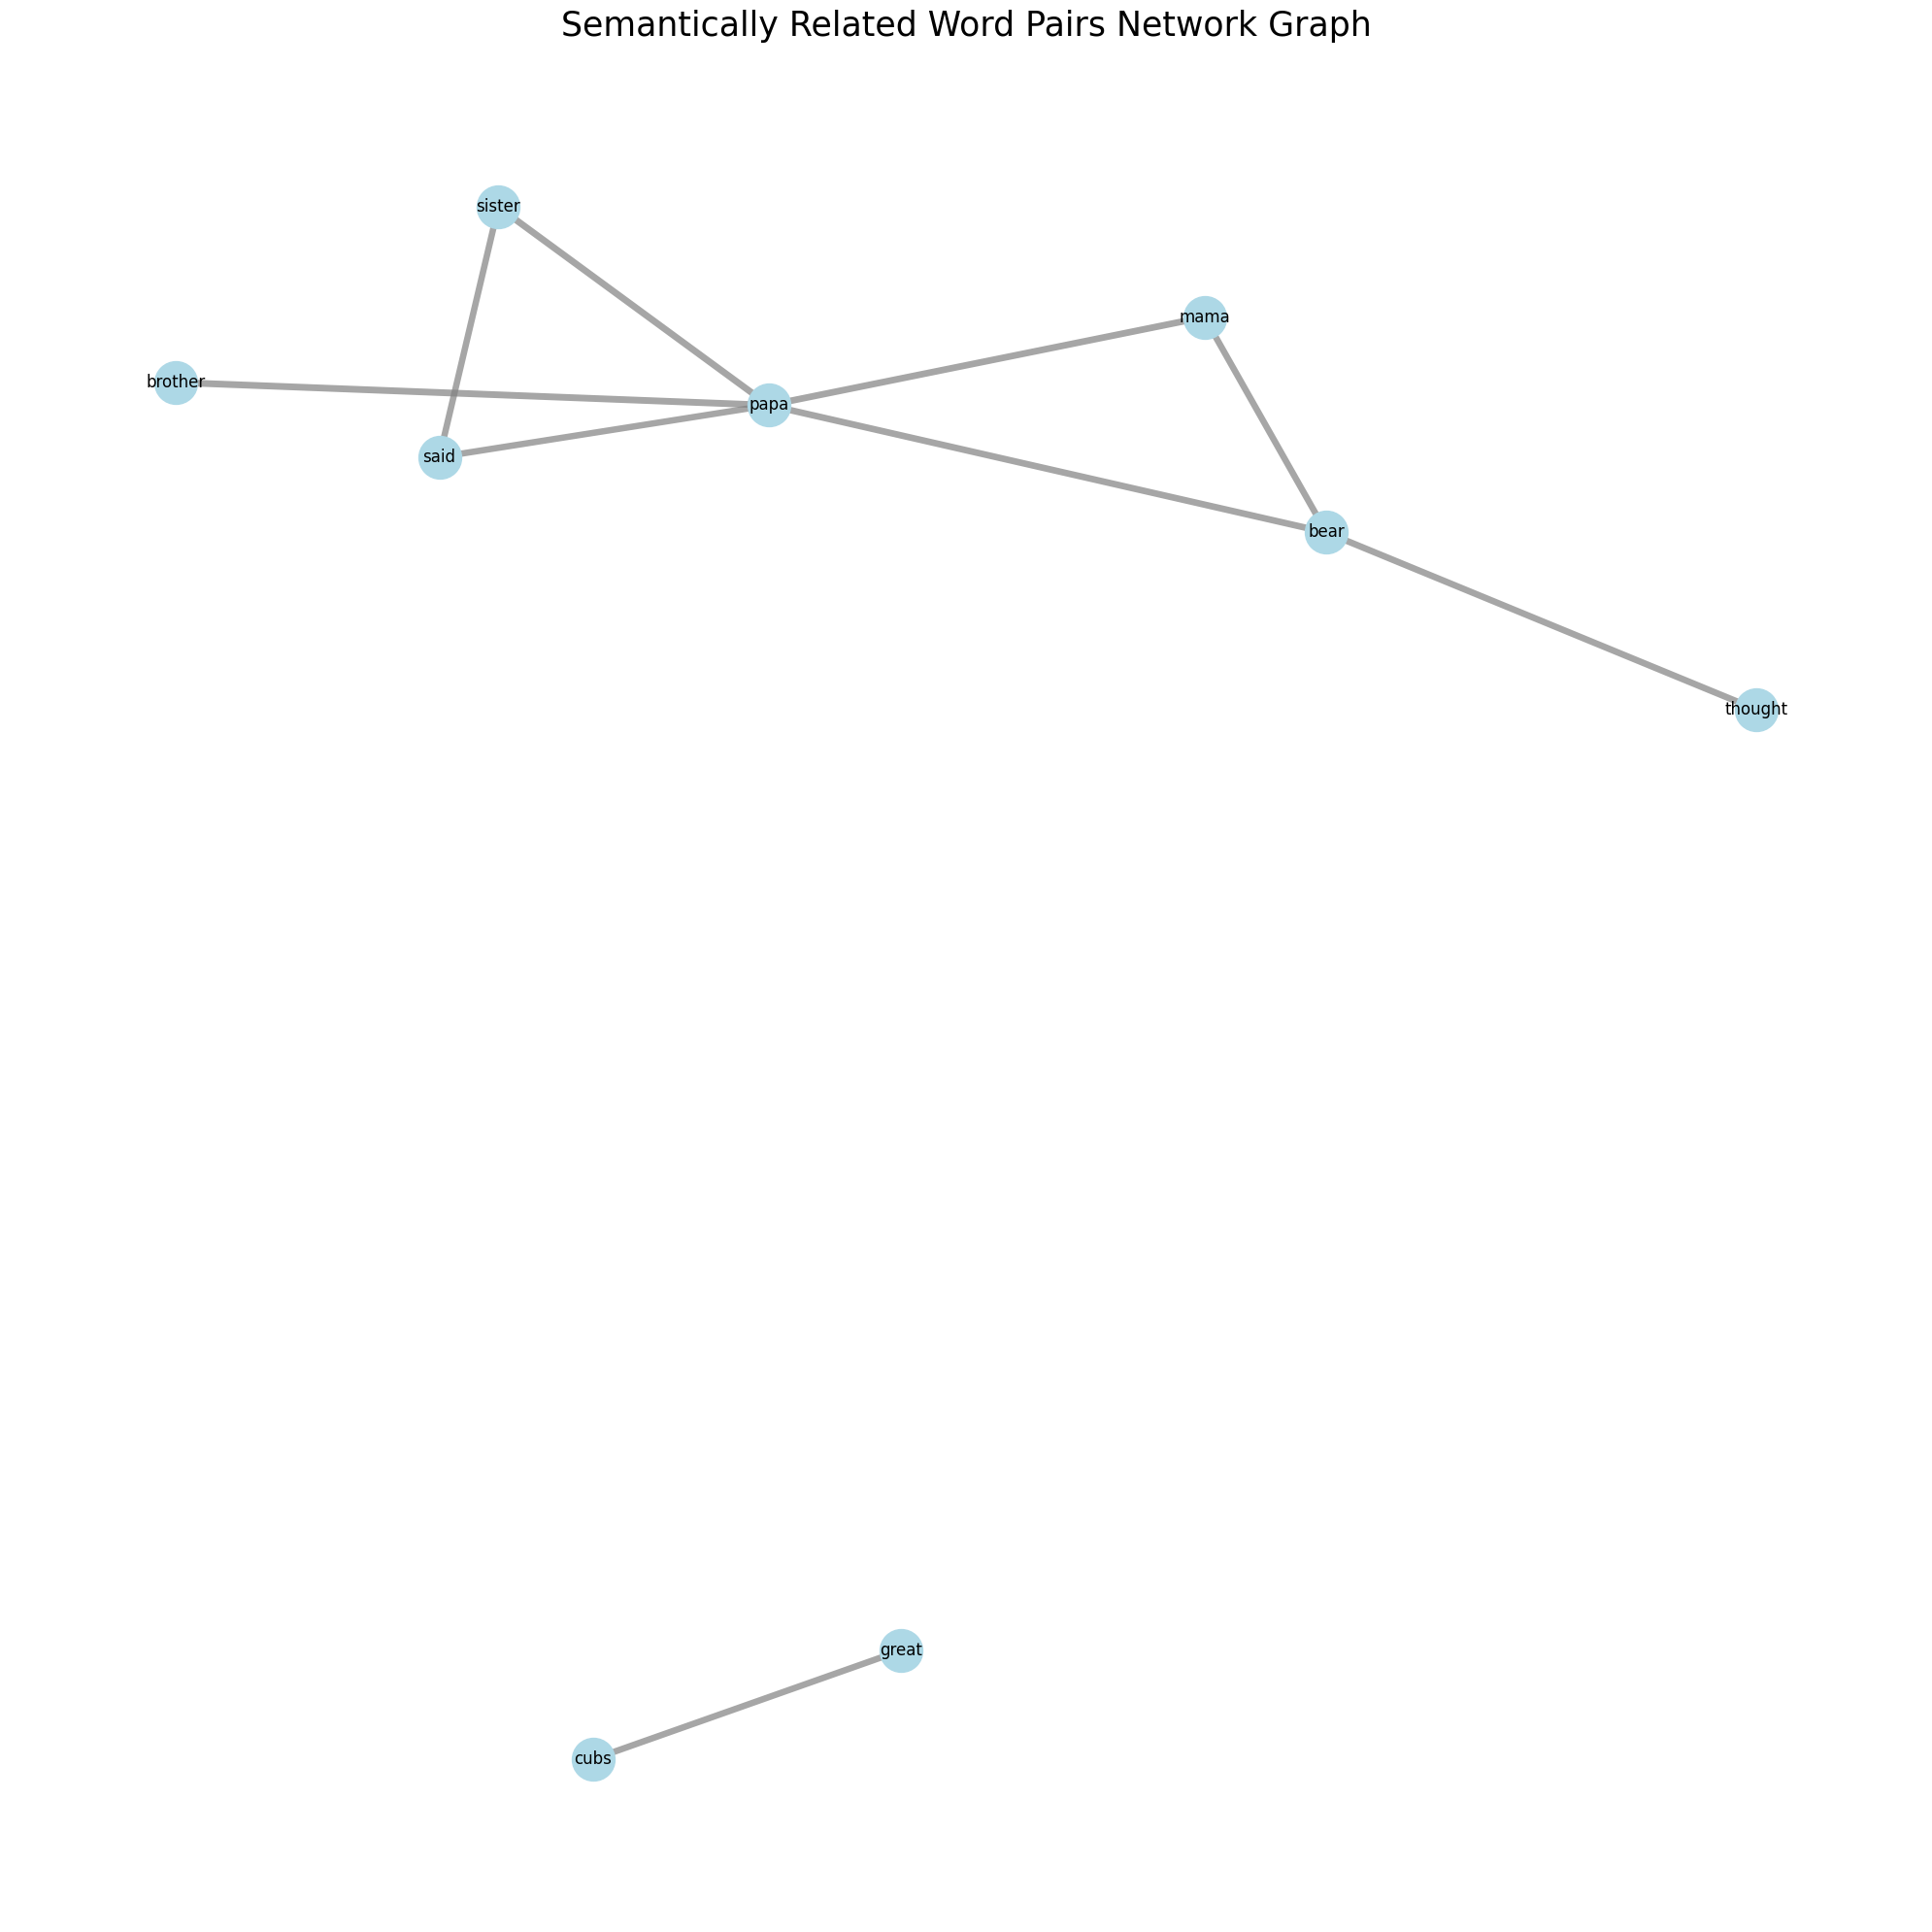

In [6]:
import pandas as pd
import nltk
from gensim.models import Word2Vec
import string
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# Step 1: Load and Verify the CSV File
def load_and_verify_csv(file_path, text_column):
    try:
        # Load the CSV file
        df = pd.read_csv(file_path)

        # Print original column names to verify
        print("Original Column Names:", df.columns.tolist())

        # Standardize column names: strip spaces and convert to lowercase
        df.columns = df.columns.str.strip().str.lower()
        print("Standardized Column Names:", df.columns.tolist())

        # Check if the text column exists
        if text_column.lower() not in df.columns:
            raise KeyError(f"Column '{text_column}' not found in the CSV file.")

        # Extract text data
        text_list = df[text_column.lower()].dropna().tolist()
        print(f"Successfully loaded {len(text_list)} text entries from '{text_column}' column.")
        return text_list
    except FileNotFoundError:
        print(f"Error: The file at '{file_path}' was not found.")
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
    except pd.errors.ParserError:
        print("Error: The file could not be parsed.")
    except KeyError as e:
        print(e)

# Step 2: Preprocess Text with Stopword Removal and POS Filtering
def preprocess_text_with_pos(text_list):
    all_tokens = []
    stop_words = set(stopwords.words('english'))
    for text in text_list:
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Tokenize words
        tokens = nltk.word_tokenize(text.lower())
        # POS tagging
        pos_tags = pos_tag(tokens)
        # Filter tokens: remove stopwords, non-alphabetic, and keep only content POS
        filtered_tokens = [
            word for word, pos in pos_tags
            if word not in stop_words and word.isalpha() and get_wordnet_pos(pos) is not None
        ]
        all_tokens.append(filtered_tokens)
    return all_tokens

# Step 3: Train Word2Vec Model
def train_word2vec_model(sentences, vector_size=100, window=5, min_count=1, workers=4): #100 dimensionality, 11 words tested each (5 words to the left, target word, 5 words to the right)
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    print("Word2Vec model training completed.")
    return model

# Step 4: Find Semantically Related Word Pairs Excluding Function Words
def find_semantically_related_pairs(model, top_n=50):
    words = list(model.wv.index_to_key)
    word_pairs = []
    stop_words = set(stopwords.words('english'))  # Reuse the stopwords set for filtering

    # Using Gensim's most_similar method to find similar words
    for word in words:
        similar_words = model.wv.most_similar(word, topn=5)  # Adjust topn as needed
        for similar_word, similarity in similar_words:
            # Ensure similar_word is not a stopword and is alphabetic
            if similar_word in stop_words:
                continue  # Skip if similar_word is a stopword
            # To avoid duplicate pairs (word1-word2 and word2-word1), sort them
            sorted_pair = tuple(sorted([word, similar_word]))
            if sorted_pair not in word_pairs:
                word_pairs.append((sorted_pair[0], sorted_pair[1], similarity))

    # Sort the pairs based on similarity
    word_pairs = sorted(word_pairs, key=lambda x: x[2], reverse=True)

    # Return the top N pairs
    return word_pairs[:top_n]

# Step 5: Generate Network Graph
def generate_network_graph(word_pairs, similarity_threshold=0.6, save_path=None):
    """
    Generates a network graph from semantically related word pairs.

    :param word_pairs: List of tuples (Word1, Word2, Similarity)
    :param similarity_threshold: Minimum similarity score to include an edge
    :param save_path: If provided, saves the graph to the specified path
    """
    G = nx.Graph()

    # Add edges with similarity above the threshold
    for word1, word2, similarity in word_pairs:
        if similarity >= similarity_threshold:
            G.add_edge(word1, word2, weight=similarity)

    if len(G.nodes) == 0:
        print("No edges meet the similarity threshold. Adjust the threshold and try again.")
        return

    # Set positions using spring layout
    pos = nx.spring_layout(G, k=0.5, iterations=50)

    # Extract edge weights for visualization
    edges = G.edges(data=True)
    weights = [edge_data['weight'] for _, _, edge_data in edges]

    # Normalize weights for edge thickness
    max_weight = max(weights) if weights else 1
    normalized_weights = [weight / max_weight * 5 for weight in weights]  # Scale edge widths

    # Draw nodes
    plt.figure(figsize=(20, 20))
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')

    # Draw edges with widths based on similarity
    nx.draw_networkx_edges(G, pos, width=normalized_weights, alpha=0.7, edge_color='gray')

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    plt.title("Semantically Related Word Pairs Network Graph", fontsize=25)
    plt.axis('off')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, format='PNG')
        print(f"Network graph saved to '{save_path}'.")

    plt.show()

# Step 6: Main Function to Execute the Workflow
def main():
    # Define file path and text column
    file_path = "/content/Ref_Scripts4Research/BerenstainBears/BerenstainBears_First9Copies_BodyOnly.csv"
    text_column = "text_column"  # Correctly set to match the actual column name

    # Load and verify the CSV
    text_list = load_and_verify_csv(file_path, text_column)
    if not text_list:
        print("No text data to process.")
        return

    # Preprocess the text with stopword removal and content word filtering
    sentences = preprocess_text_with_pos(text_list)

    # Debug: Print sample preprocessed sentences
    print("\nSample Preprocessed Sentences:")
    for i, sentence in enumerate(sentences[:3], 1):
        print(f"{i}: {sentence}")

    # Train the Word2Vec model
    model = train_word2vec_model(sentences)

    # Find semantically related word pairs excluding function words
    top_n = 50  # Reduced to 50 for a smaller dataset
    related_word_pairs = find_semantically_related_pairs(model, top_n)

    # Debug: Print the found word pairs and their similarity scores
    print("\nSemantically Related Word Pairs:")
    for pair in related_word_pairs:
        print(f"{pair[0]} - {pair[1]}: Similarity = {pair[2]:.4f}")

    # Create a DataFrame from the related word pairs
    df_pairs = pd.DataFrame(related_word_pairs, columns=['Word1', 'Word2', 'Similarity'])

    # Save the results to a CSV file
    output_file = "/content/semantically_related_word_pairs.csv"
    df_pairs.to_csv(output_file, index=False)
    print(f"\nTop {top_n} Semantically Related Word Pairs saved to '{output_file}'.")

    # Generate Network Graph with a lower similarity threshold
    print("\nGenerating network graph...")
    similarity_threshold = 0.6  # Lowered threshold to include more edges
    generate_network_graph(related_word_pairs, similarity_threshold=similarity_threshold, save_path="/content/semantically_related_word_pairs_graph.png")

# Execute the main function
if __name__ == "__main__":
    main()


# **[ALERT]** The following script did not exclude quotes within quoted sentences. So, DO NOT USE the following script. I just decided to keep it for further reference.**

In [ ]:
import pandas as pd
import nltk
from gensim.models import Word2Vec
import string
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Download 'punkt' tokenizer if not already downloaded
nltk.download('punkt')

# Step 1: Load and Verify the CSV File
def load_and_verify_csv(file_path, text_column):
    try:
        # Load the CSV file
        df = pd.read_csv(file_path)

        # Standardize column names: strip spaces and convert to lowercase
        df.columns = df.columns.str.strip().str.lower()

        # Check if the text column exists
        if text_column.lower() not in df.columns:
            raise KeyError(f"Column '{text_column}' not found in the CSV file.")

        # Extract text data
        text_list = df[text_column.lower()].dropna().tolist()
        print(f"Successfully loaded {len(text_list)} text entries from '{text_column}' column.")
        return text_list
    except FileNotFoundError:
        print(f"Error: The file at '{file_path}' was not found.")
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
    except pd.errors.ParserError:
        print("Error: The file could not be parsed.")
    except KeyError as e:
        print(e)

# Step 2: Preprocess Text
def preprocess_text(text_list):
    all_tokens = []
    for text in text_list:
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Tokenize words
        tokens = nltk.word_tokenize(text.lower())
        all_tokens.append(tokens)
    return all_tokens

# Step 3: Train Word2Vec Model
def train_word2vec_model(sentences, vector_size=100, window=5, min_count=1, workers=4):
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    print("Word2Vec model training completed.")
    return model

# Step 4: Find Semantically Related Word Pairs
def find_semantically_related_pairs(model, top_n=1000):
    words = list(model.wv.index_to_key)
    word_pairs = []

    # Using Gensim's most_similar method to find similar words
    for word in words:
        similar_words = model.wv.most_similar(word, topn=5)  # Adjust topn as needed
        for similar_word, similarity in similar_words:
            # To avoid duplicate pairs (word1-word2 and word2-word1), sort them
            sorted_pair = tuple(sorted([word, similar_word]))
            if sorted_pair not in word_pairs:
                word_pairs.append((sorted_pair[0], sorted_pair[1], similarity))

    # Sort the pairs based on similarity
    word_pairs = sorted(word_pairs, key=lambda x: x[2], reverse=True)

    # Return the top N pairs
    return word_pairs[:top_n]

# Step 5: Main Function to Execute the Workflow
def main():
    # Define file path and text column
    file_path = "/content/Ref_Scripts4Research/BerenstainBears/BerenstainBears_First9Copies_BodyOnly.csv"
    text_column = "text_column"  # Ensure this matches the actual column name

    # Load and verify the CSV
    text_list = load_and_verify_csv(file_path, text_column)
    if not text_list:
        print("No text data to process.")
        return

    # Preprocess the text
    sentences = preprocess_text(text_list)

    # Train the Word2Vec model
    model = train_word2vec_model(sentences)

    # Find semantically related word pairs
    top_n = 1000  # Number of top related word pairs to display
    related_word_pairs = find_semantically_related_pairs(model, top_n)

    # Display the results
    print(f"\nTop {top_n} Semantically Related Word Pairs:")
    for idx, (word1, word2, similarity) in enumerate(related_word_pairs, 1):
        print(f"{idx}. {word1} - {word2} : Similarity = {similarity:.4f}")

# Execute the main function
if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Successfully loaded 9 text entries from 'text_column' column.
Word2Vec model training completed.

Top 1000 Semantically Related Word Pairs:
1. it - the : Similarity = 0.9998
2. it - the : Similarity = 0.9998
3. and - of : Similarity = 0.9998
4. and - of : Similarity = 0.9998
5. of - ” : Similarity = 0.9998
6. of - ” : Similarity = 0.9998
7. and - the : Similarity = 0.9998
8. and - the : Similarity = 0.9998
9. of - the : Similarity = 0.9998
10. of - the : Similarity = 0.9998
11. and - ” : Similarity = 0.9998
12. and - ” : Similarity = 0.9998
13. and - in : Similarity = 0.9997
14. and - in : Similarity = 0.9997
15. and - to : Similarity = 0.9997
16. and - “ : Similarity = 0.9997
17. and - to : Similarity = 0.9997
18. a - ” : Similarity = 0.9997
19. a - ” : Similarity = 0.9997
20. the - ” : Similarity = 0.9997
21. the - ” : Similarity = 0.9997
22. sister - the : Similarity = 0.9997
23. sister - the : Similarity = 0.9997
24. to - ” : Similarity = 0.9997
25. to - ” : Similarity = 0.9997
26.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Original Column Names: ['text_column']
Standardized Column Names: ['text_column']
Successfully loaded 9 text entries from 'text_column' column.
Word2Vec model training completed.

Top 100 Semantically Related Word Pairs saved to '/content/semantically_related_word_pairs.csv'.

Generating network graph...


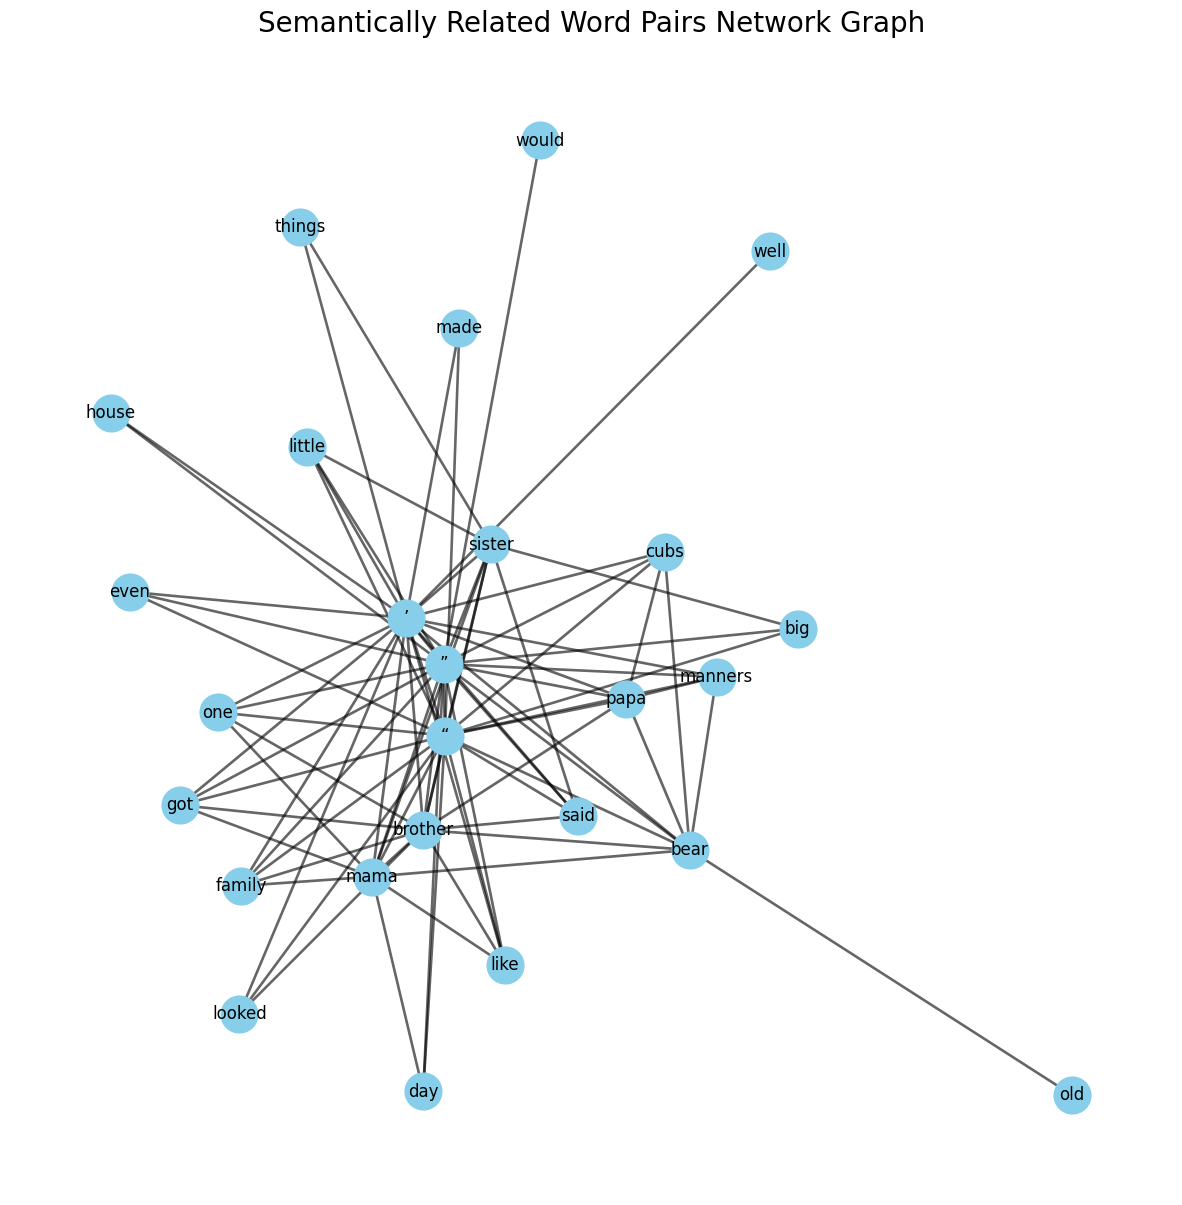

In [ ]:
import pandas as pd
import nltk
from gensim.models import Word2Vec
import string
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords

# Step 1: Load and Verify the CSV File
def load_and_verify_csv(file_path, text_column):
    try:
        # Load the CSV file
        df = pd.read_csv(file_path)

        # Print original column names to verify
        print("Original Column Names:", df.columns.tolist())

        # Standardize column names: strip spaces and convert to lowercase
        df.columns = df.columns.str.strip().str.lower()
        print("Standardized Column Names:", df.columns.tolist())

        # Check if the text column exists
        if text_column.lower() not in df.columns:
            raise KeyError(f"Column '{text_column}' not found in the CSV file.")

        # Extract text data
        text_list = df[text_column.lower()].dropna().tolist()
        print(f"Successfully loaded {len(text_list)} text entries from '{text_column}' column.")
        return text_list
    except FileNotFoundError:
        print(f"Error: The file at '{file_path}' was not found.")
    except pd.errors.EmptyDataError:
        print("Error: The file is empty.")
    except pd.errors.ParserError:
        print("Error: The file could not be parsed.")
    except KeyError as e:
        print(e)

# Step 2: Preprocess Text with Stopword Removal
def preprocess_text(text_list):
    all_tokens = []
    stop_words = set(stopwords.words('english'))  # Adjust language as needed
    for text in text_list:
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Tokenize words
        tokens = nltk.word_tokenize(text.lower())
        # Remove stopwords
        filtered_tokens = [word for word in tokens if word not in stop_words]
        all_tokens.append(filtered_tokens)
    return all_tokens

# Step 3: Train Word2Vec Model
def train_word2vec_model(sentences, vector_size=100, window=5, min_count=1, workers=4):
    model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    print("Word2Vec model training completed.")
    return model

# Step 4: Find Semantically Related Word Pairs
def find_semantically_related_pairs(model, top_n=100):
    words = list(model.wv.index_to_key)
    word_pairs = []

    # Using Gensim's most_similar method to find similar words
    for word in words:
        similar_words = model.wv.most_similar(word, topn=5)  # Adjust topn as needed
        for similar_word, similarity in similar_words:
            # To avoid duplicate pairs (word1-word2 and word2-word1), sort them
            sorted_pair = tuple(sorted([word, similar_word]))
            if sorted_pair not in word_pairs:
                word_pairs.append((sorted_pair[0], sorted_pair[1], similarity))

    # Sort the pairs based on similarity
    word_pairs = sorted(word_pairs, key=lambda x: x[2], reverse=True)

    # Return the top N pairs
    return word_pairs[:top_n]

# Step 5: Generate Network Graph
def generate_network_graph(word_pairs, similarity_threshold=0.8):
    """
    Generates a network graph from semantically related word pairs.

    :param word_pairs: List of tuples (Word1, Word2, Similarity)
    :param similarity_threshold: Minimum similarity score to include an edge
    """
    G = nx.Graph()

    # Add edges with similarity above the threshold
    for word1, word2, similarity in word_pairs:
        if similarity >= similarity_threshold:
            G.add_edge(word1, word2, weight=similarity)

    # Set positions using spring layout
    pos = nx.spring_layout(G, k=0.5, iterations=50)

    # Extract edge weights for visualization
    edges = G.edges(data=True)
    weights = [edge_data['weight'] for _, _, edge_data in edges]

    # Draw nodes
    plt.figure(figsize=(15, 15))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue')

    # Draw edges with widths based on similarity
    nx.draw_networkx_edges(G, pos, width=[weight * 2 for weight in weights], alpha=0.6)

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

    plt.title("Semantically Related Word Pairs Network Graph", fontsize=20)
    plt.axis('off')
    plt.show()

# Step 6: Main Function to Execute the Workflow
def main():
    # Define file path and text column
    file_path = "/content/Ref_Scripts4Research/BerenstainBears/BerenstainBears_First9Copies_BodyOnly.csv"
    text_column = "text_column"  # Ensure this matches the actual column name

    # Load and verify the CSV
    text_list = load_and_verify_csv(file_path, text_column)
    if not text_list:
        print("No text data to process.")
        return

    # Preprocess the text with stopword removal
    sentences = preprocess_text(text_list)

    # Train the Word2Vec model
    model = train_word2vec_model(sentences)

    # Find semantically related word pairs
    top_n = 100  # Number of top related word pairs to display
    related_word_pairs = find_semantically_related_pairs(model, top_n)

    # Create a DataFrame from the related word pairs
    df_pairs = pd.DataFrame(related_word_pairs, columns=['Word1', 'Word2', 'Similarity'])

    # Save the results to a CSV file
    output_file = "/content/semantically_related_word_pairs.csv"
    df_pairs.to_csv(output_file, index=False)
    print(f"\nTop {top_n} Semantically Related Word Pairs saved to '{output_file}'.")

    # Generate Network Graph
    print("\nGenerating network graph...")
    generate_network_graph(related_word_pairs, similarity_threshold=0.8)  # Adjust threshold as needed

# Execute the main function
if __name__ == "__main__":
    main()


#**🐣🐣🐣🐣🐣 <font color = 'pink'>The following scripts are for basic analysis.**

In [21]:
! git clone https://github.com/ms624atyale/Ref_Scripts4Research

fatal: destination path 'Ref_Scripts4Research' already exists and is not an empty directory.


In [22]:
file = open("/content/Ref_Scripts4Research/BerenstainBears/BerenstainBears_First9Copies_BodyOnly.csv")
text = file.read().replace("\n", " ")
file.close()

In [23]:
file = open("tmp.txt", "w")
file.write(text)
file.close()

🆘 _Refresh the directory to confirm <temp.txt>_

In [27]:
#text.lower() #PB. When I applied this codeline (text.lower()), it does not work with the written text.
#Using porterstemmer down in the script, we have small letters. So don't worry about the lower() function here.
words_split = text.split()
print(words_split)

['\ufefftext_column', '"Down', 'a', 'sunny', 'dirt', 'road,', 'over', 'a', 'log', 'bridge,', 'up', 'a', 'grassy', 'hill,', 'deep', 'in', 'Bear', 'Country,', 'lived', 'a', 'family', 'of', 'bears—Papa', 'Bear,', 'Mama', 'Bear', 'and', 'Small', 'Bear.', 'They', 'lived', 'in', 'a', 'large', 'tree', 'which', 'Papa', 'Bear', 'had', 'hollowed', 'out', 'and', 'made', 'into', 'a', 'house.', 'It', 'was', 'a', 'very', 'fine', 'house.', 'This', 'is', 'what', 'it', 'looked', 'like', 'inside.', 'It', 'was', 'fun', 'growing', 'up', 'in', 'Bear', 'Country...helping', 'Papa', 'get', 'honey', 'from', 'the', 'old', 'bee', 'tree...helping', 'Mama', 'bring', 'the', 'vegetables', 'in', 'from', 'the', 'garden.', 'There', 'were', 'all', 'sorts', 'of', 'interesting', 'things', 'for', 'a', 'small', 'bear', 'to', 'do', 'and', 'see', 'in', 'Bear-Country.', 'Small', 'Bear', 'felt', 'good', 'growing', 'up', 'in', 'a', 'tree...in', 'his', 'own', 'room...in', 'the', 'snug', 'little', 'bed', 'that', 'Papa', 'Bear', 'h

In [11]:
' '.join(text.split()) #uses a single space (' ') to join the words back together.

'\ufefftext_column "Down a sunny dirt road, over a log bridge, up a grassy hill, deep in Bear Country, lived a family of bears—Papa Bear, Mama Bear and Small Bear. They lived in a large tree which Papa Bear had hollowed out and made into a house. It was a very fine house. This is what it looked like inside. It was fun growing up in Bear Country...helping Papa get honey from the old bee tree...helping Mama bring the vegetables in from the garden. There were all sorts of interesting things for a small bear to do and see in Bear-Country. Small Bear felt good growing up in a tree...in his own room...in the snug little bed that Papa Bear had made for him when he was a baby. But one morning, it did not feel so good. Small Bear woke up with pains in his knees and aches in his legs. “Small Bear, you have outgrown your little bed,” said Papa Bear, as he hitched up his overalls and buttoned his shoulder straps. “Today, we shall go out into the woods and make you a bigger one!” With that, he ate 

## 🚦 **<font color = 'yellow'> I need to know why the following script does not work properly..** ⤵️

In [12]:
#The following codes do not work. Just a try for a possible topic for the upcoming paper.
import nltk
import string

# Ensure nltk resources are available
nltk.download('punkt')

# Define a list of common function words
function_words = set([
    'i', 'my','me', 'you', 'your', 'you', 'he', 'his', 'him', 'she', 'her', 'it', 'its', 'we', 'our', 'us', 'they', 'their', 'them',
    'myself', 'yourself', 'himself', 'herself', 'itself', 'ourselves', 'yourselves', 'themselves', 'mine', 'yours','hers', 'ours', 'thiers'   # Pronouns
    'the', 'a', 'an', 'this', 'that', 'these', 'those',                            # Articles, demonstratives
    'about', 'above','across','after','against','along','among','around','at','before','behind',
    'below' ,'beneath' ,'beside', 'between','beyond','by' ,'despite' ,'during' ,'except' ,'for' ,
    'from' ,'in' ,'inside' ,'into' ,'like' ,'near' ,'of' ,'off' ,'on' ,'onto',
    'out' ,'outside' ,'over' ,'past' ,'since' ,'through' ,'throughout' ,'to' ,'toward' ,'towards',
    'under' ,'underneath' ,'until' ,'up' ,'upon' ,'with' ,'within' ,'without'    # Prepositions
    'and', 'or', 'but', 'if', 'because', 'while', 'although', 'since', 'unless',   # Conjunctions
    'is', 'am', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', # Auxiliaries
    'do', 'does', 'did', 'can', 'could', 'will', 'would', 'shall', 'should', 'may', 'might', # Modals
])



# Function to load the text from a UTF-8 file
def file_content = load_csv("/content/Ref_Scripts4Research/BerenstainBears/BerenstainBears_First9Copies_BodyOnly.csv"):
    with open("/content/Ref_Scripts4Research/BerenstainBears/BerenstainBears_First9Copies_BodyOnly.csv", 'r', encoding='utf-8') as file:
        text = file.read()
    return text

# Function to tokenize and clean text
def tokenize_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize words using nltk
    tokens = nltk.word_tokenize(text.lower())  # Lowercase for case-insensitivity
    return tokens

# Function to classify words into function or content words
def classify_words(tokens):
    function_word_count = 0
    content_word_count = 0

    for word in tokens:
        if word in function_words:
            function_word_count += 1
        else:
            content_word_count += 1

    return function_word_count, content_word_count

# Function to calculate the proportion of function words vs content words
def calculate_proportion(function_word_count, content_word_count):
    total_words = function_word_count + content_word_count
    if total_words == 0:
        return 0, 0  # Avoid division by zero
    function_word_proportion = function_word_count / total_words
    content_word_proportion = content_word_count / total_words
    return function_word_proportion, content_word_proportion

# Main function to process the text file
def estimate_function_content_word_proportion(file_path):
    # Step 1: Load the text from the file
    text = load_text(file_path)

    # Step 2: Tokenize the text
    tokens = tokenize_text(text)

    # Step 3: Classify words into function and content words
    function_word_count, content_word_count = classify_words(tokens)

    # Step 4: Calculate the proportions
    function_word_proportion, content_word_proportion = calculate_proportion(function_word_count, content_word_count)

    # Print the results
    print(f"Function Word Proportion: {function_word_proportion:.2f}")
    print(f"Content Word Proportion: {content_word_proportion:.2f}")
    print(f"Total Function Words: {function_word_count}")
    print(f"Total Content Words: {content_word_count}")

# Example usage (replace 'your_text_file.txt' with the actual file path)
file_path = 'your_text_file.txt'
estimate_function_content_word_proportion(file_path)

SyntaxError: invalid syntax (<ipython-input-12-64da13497487>, line 26)

# 📌📎 <font color = 'orange'> **Keep the following sripts for furher references** ⤵️

In [13]:
!pip install nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.text import Text

nltk.download('punkt') # Download the punkt tokenizer data

#Step 1: Tokenize the text
tokens = word_tokenize(text.lower())  # Tokenize the text and convert to lowercase

# Step 2: Create an NLTK Text object from the list of words.
text_object = nltk.Text(tokens)
print('\n')
print(text_object)

# Count subject pronoun limited to 'he' and 'they' (due to overlap between paradigm for femine and neuter)
print('\n')
#Subject
# Define the specific words you want to count
specific_words_allcasepronouns = ['i', 'you', 'he', 'she', 'it', 'they','my', 'your', 'his', 'her', 'its', 'their', 'me', 'you', 'him', 'her', 'it', 'them', 'myself', 'yourself', 'himself', 'herself', 'itself', 'ourselves', 'yourselves', 'ourselves', 'themselves']

# Filter the tokens to include only the specific words
filtered_tokens_allcasepronouns = [word for word in tokens if word in specific_words_allcasepronouns]

# Count the number of occurrences of the specific words
count_specific_words_allcasepronouns = len(filtered_tokens_allcasepronouns)
# Output the count
print(f"Count of specific words_allcasepronouns: {count_specific_words_allcasepronouns}")

# Define the specific words you want to count
specific_words_1stpersonpronouns = ['i', 'my', 'me', 'myself' ]

# Filter the tokens to include only the specific words
filtered_tokens_1stpersonpronouns = [word for word in tokens if word in specific_words_1stpersonpronouns ]

# Count the number of occurrences of the specific words
count_specific_words_1stpersonpronouns = len(filtered_tokens_1stpersonpronouns)
# Output the count
print(f"Count of specific words_1stpersonpronouns: {count_specific_words_1stpersonpronouns}")

# Define the specific words you want to count
specific_words_2ndpersonpronouns = ['you', 'your', 'you', 'yourself']

# Filter the tokens to include only the specific words
filtered_tokens_2ndpersonpronouns = [word for word in tokens if word in specific_words_2ndpersonpronouns]

# Count the number of occurrences of the specific words
count_specific_words_2ndpersonpronouns = len(filtered_tokens_2ndpersonpronouns)
# Output the count
print(f"Count of specific words_2ndpersonpronouns: {count_specific_words_2ndpersonpronouns}")

# Define the specific words you want to count
specific_words_malepronouns = ['he', 'his', 'him', 'himself' ]

# Filter the tokens to include only the specific words
filtered_tokens_malepronouns = [word for word in tokens if word in specific_words_malepronouns]

# Count the number of occurrences of the specific words
count_specific_words_malepronouns = len(filtered_tokens_malepronouns)
# Output the count
print(f"Count of specific words_malepronouns: {count_specific_words_malepronouns}")

# Define the specific words you want to count
specific_words_femalepronouns = ['she', 'her', 'her', 'herself' ]

# Filter the tokens to include only the specific words
filtered_tokens_femalepronouns = [word for word in tokens if word in specific_words_femalepronouns]

# Count the number of occurrences of the specific words
count_specific_words_femalepronouns = len(filtered_tokens_femalepronouns)
# Output the count
print(f"Count of specific words_femalepronouns: {count_specific_words_femalepronouns}")

# Define the specific words you want to count
specific_words_neuterpronouns = ['it', 'its', 'it', 'itself' ]

# Filter the tokens to include only the specific words
filtered_tokens_neuterpronouns = [word for word in tokens if word in specific_words_neuterpronouns]

# Count the number of occurrences of the specific words
count_specific_words_neuterpronouns = len(filtered_tokens_neuterpronouns)
# Output the count
print(f"Count of specific words_neuterpronouns: {count_specific_words_neuterpronouns}")

# Define the specific words you want to count
specific_words_1stpluralpronouns = ['we', 'our', 'us', 'ourselves']

# Filter the tokens to include only the specific words
filtered_tokens_1stpluralpronouns = [word for word in tokens if word in specific_words_1stpluralpronouns]

# Count the number of occurrences of the specific words
count_specific_words_1stpluralpronouns = len(filtered_tokens_1stpluralpronouns)
# Output the count
print(f"Count of specific words_1stpluralpronouns: {count_specific_words_1stpluralpronouns}")

# Define the specific words you want to count
specific_words_3rdpluralpronouns = ['they', 'their', 'them', 'themselves']

# Filter the tokens to include only the specific words
filtered_tokens_3rdpluralpronouns = [word for word in tokens if word in specific_words_3rdpluralpronouns]

# Count the number of occurrences of the specific words
count_specific_words_3rdpluralpronouns = len(filtered_tokens_3rdpluralpronouns)
# Output the count
print(f"Count of specific words_3rdpluralpronouns: {count_specific_words_3rdpluralpronouns}")


# Count subject pronoun limited to 'he' and 'they' (due to overlap between paradigm for femine and neuter)
print('\n')
#Subject
# Define the specific words you want to count
specific_words_he_they = ['he', 'they']

# Filter the tokens to include only the specific words
filtered_tokens_he_they = [word for word in tokens if word in specific_words_he_they]

# Count the number of occurrences of the specific words
count_specific_words_he_they = len(filtered_tokens_he_they)

# Output the count
print(f"Count of specific words_he_they: {count_specific_words_he_they}")

print('\n')
#Possessive
# Define the specific words you want to count
specific_words_his_their = ['his', 'their']

# Filter the tokens to include only the specific words
filtered_tokens_his_their = [word for word in tokens if word in specific_words_his_their]

# Count the number of occurrences of the specific words
count_specific_words_his_their = len(filtered_tokens_his_their)

# Output the count
print(f"Count of specific words_his_their: {count_specific_words_his_their}")

print('\n')
#Object

# Define the specific words you want to count
specific_words_him_them = ['him', 'them']

# Filter the tokens to include only the specific words
filtered_tokens_him_them = [word for word in tokens if word in specific_words_him_them]

# Count the number of occurrences of the specific words
count_specific_words_him_them = len(filtered_tokens_him_them)

# Output the count
print(f"Count of specific words_him_them: {count_specific_words_him_them}")

# Define the specific words you want to count
specific_words_3rdplreflexivepronouns = ['himself', 'themselves']

# Filter the tokens to include only the specific words
filtered_tokens_3rdplreflexivepronouns = [word for word in tokens if word in specific_words_3rdplreflexivepronouns]

# Count the number of occurrences of the specific words
count_specific_words_3rdplreflexivepronouns = len(filtered_tokens_3rdplreflexivepronouns)

# Output the count
print(f"Count of specific words_3rdplreflexivepronouns: {count_specific_words_3rdplreflexivepronouns}")





<Text: ﻿text_column `` down a sunny dirt road ,...>


Count of specific words_allcasepronouns: 821
Count of specific words_1stpersonpronouns: 113
Count of specific words_2ndpersonpronouns: 132
Count of specific words_malepronouns: 135
Count of specific words_femalepronouns: 153
Count of specific words_neuterpronouns: 157
Count of specific words_1stpluralpronouns: 49
Count of specific words_3rdpluralpronouns: 130


Count of specific words_he_they: 150


Count of specific words_his_their: 76


Count of specific words_him_them: 39
Count of specific words_3rdplreflexivepronouns: 0


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#<font color = 'sky blue'> **1 Paradigm of Pronoun**

In [29]:
! git clone https://github.com/ms624atyale/Ref_Scripts4Research

file = open("/content/Ref_Scripts4Research/BerenstainBears/BerenstainBears_First9Copies_BodyOnly.csv")
text = file.read().replace("\n", " ")
file.close()


!pip install nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.text import Text

nltk.download('punkt') # Download the punkt tokenizer data

#Step 1: Tokenize the text & lowercase
tokens = word_tokenize(text.lower())  # Tokenize the text and convert to lowercase

# Step 2: Create an NLTK Text object from the list of words.
text_object = nltk.Text(tokens)
print('\n')
print(text_object)

# Count subject pronoun limited to 'he' and 'they' (due to overlap between paradigm for femine and neuter)
print('\n')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!




<Text: ﻿text_column `` down a sunny dirt road ,...>




##<font color = 'sky blue'> **1-1. Paradigm: 1st person sigular (nom-possessive-acc)**

In [30]:
# Define the specific words you want to count
specific_words_1stSgNominative = ['i'] # Use lowercase only!!!

# Filter the tokens to include only the specific words
filtered_tokens_1stSgNominative = [word for word in tokens if word in specific_words_1stSgNominative]

# Count the number of occurrences of the specific words
count_specific_words_1stSgNominative = len(filtered_tokens_1stSgNominative)
# Output the count
print(f"Count of specific words_1stSgNominative 'i': {count_specific_words_1stSgNominative}")



# Define the specific words you want to count
specific_words_1stSgPosessive = ['my']

# Filter the tokens to include only the specific words
filtered_tokens_1stSgPosessive = [word for word in tokens if word in specific_words_1stSgPosessive]

# Count the number of occurrences of the specific words
count_specific_words_1stSgPosessive = len(filtered_tokens_1stSgPosessive)
# Output the count
print(f"Count of specific words_1stSgPosessive 'my': {count_specific_words_1stSgPosessive}")



# Define the specific words you want to count
specific_words_1stSgAccusative = ['me']

# Filter the tokens to include only the specific words
filtered_tokens_1stSgAccusative = [word for word in tokens if word in specific_words_1stSgAccusative]

# Count the number of occurrences of the specific words
count_specific_words_1stSgAccusative = len(filtered_tokens_1stSgAccusative)
# Output the count
print(f"Count of specific words_1stSgAccusative 'me': {count_specific_words_1stSgAccusative}")

Count of specific words_1stSgNominative 'i': 64
Count of specific words_1stSgPosessive 'my': 31
Count of specific words_1stSgAccusative 'me': 18


##<font color = 'sky blue'> **1-2. Paradigm: 1st person plural (nom-possessive-acc)**

In [31]:
# Define the specific words you want to count
specific_words_1stPlNominative = ['we']

# Filter the tokens to include only the specific words
filtered_tokens_1stPlNominative = [word for word in tokens if word in specific_words_1stPlNominative]

# Count the number of occurrences of the specific words
count_specific_words_1stPlNominative = len(filtered_tokens_1stPlNominative)
# Output the count
print(f"Count of specific words_1stPlNominative 'we': {count_specific_words_1stPlNominative}")



# Define the specific words you want to count
specific_words_1stPlPosessive = ['our']

# Filter the tokens to include only the specific words
filtered_tokens_1stPlPosessive = [word for word in tokens if word in specific_words_1stPlPosessive]

# Count the number of occurrences of the specific words
count_specific_words_1stPlPosessive = len(filtered_tokens_1stPlPosessive)
# Output the count
print(f"Count of specific words_1stPlPosessive 'our': {count_specific_words_1stPlPosessive}")



# Define the specific words you want to count
specific_words_1stPlAccusative = ['us']

# Filter the tokens to include only the specific words
filtered_tokens_1stPlAccusative = [word for word in tokens if word in specific_words_1stPlAccusative]

# Count the number of occurrences of the specific words
count_specific_words_1stPlAccusative = len(filtered_tokens_1stPlAccusative)
# Output the count
print(f"Count of specific words_1stPlAccusative 'us': {count_specific_words_1stPlAccusative}")

Count of specific words_1stPlNominative 'we': 34
Count of specific words_1stPlPosessive 'our': 7
Count of specific words_1stPlAccusative 'us': 8


##<font color = 'sky blue'> **1-3. Paradigm: 3rd person sigular (nom-possessive-acc)**

In [32]:
# Define the specific words you want to count
specific_words_3rdSgNominative = ['he']

# Filter the tokens to include only the specific words
filtered_tokens_3rdSgNominative = [word for word in tokens if word in specific_words_3rdSgNominative]

# Count the number of occurrences of the specific words
count_specific_words_3rdSgNominative = len(filtered_tokens_3rdSgNominative)
# Output the count
print(f"Count of specific words_3rdSgNominative 'he': {count_specific_words_3rdSgNominative}")



# Define the specific words you want to count
specific_words_3rdSgPosessive = ['his']

# Filter the tokens to include only the specific words
filtered_tokens_3rdSgPosessive = [word for word in tokens if word in specific_words_3rdSgPosessive]

# Count the number of occurrences of the specific words
count_specific_words_3rdSgPosessive = len(filtered_tokens_3rdSgPosessive)
# Output the count
print(f"Count of specific words_3rdSgPosessive 'his': {count_specific_words_3rdSgPosessive}")



# Define the specific words you want to count
specific_words_3rdSgAccusative = ['him']

# Filter the tokens to include only the specific words
filtered_tokens_3rdSgAccusative = [word for word in tokens if word in specific_words_3rdSgAccusative]

# Count the number of occurrences of the specific words
count_specific_words_3rdSgAccusative = len(filtered_tokens_3rdSgAccusative)
# Output the count
print(f"Count of specific words_3rdSgAccusative 'him': {count_specific_words_3rdSgAccusative}")

Count of specific words_3rdSgNominative 'he': 67
Count of specific words_3rdSgPosessive 'his': 49
Count of specific words_3rdSgAccusative 'him': 19


##<font color = 'sky blue'> **1-4. Paradigm: 3rd person plural (nom-possessive-acc)**

In [33]:
# Define the specific words you want to count
specific_words_3rdPlNominative = ['they']

# Filter the tokens to include only the specific words
filtered_tokens_3rdPlNominative = [word for word in tokens if word in specific_words_3rdPlNominative]

# Count the number of occurrences of the specific words
count_specific_words_3rdPlNominative = len(filtered_tokens_3rdPlNominative)
# Output the count
print(f"Count of specific words_3rdPlNominative 'they': {count_specific_words_3rdPlNominative}")



# Define the specific words you want to count
specific_words_3rdPlPosessive = ['their']

# Filter the tokens to include only the specific words
filtered_tokens_3rdPlPosessive = [word for word in tokens if word in specific_words_3rdPlPosessive]

# Count the number of occurrences of the specific words
count_specific_words_3rdPlPosessive = len(filtered_tokens_3rdPlPosessive)
# Output the count
print(f"Count of specific words_3rdPlPosessive 'their': {count_specific_words_3rdPlPosessive}")



# Define the specific words you want to count
specific_words_3rdPlAccusative = ['them']

# Filter the tokens to include only the specific words
filtered_tokens_3rdPlAccusative = [word for word in tokens if word in specific_words_3rdPlAccusative]

# Count the number of occurrences of the specific words
count_specific_words_3rdPlAccusative = len(filtered_tokens_3rdPlAccusative)
# Output the count
print(f"Count of specific words_3rdPlAccusative 'them': {count_specific_words_3rdPlAccusative}")

Count of specific words_3rdPlNominative 'they': 83
Count of specific words_3rdPlPosessive 'their': 27
Count of specific words_3rdPlAccusative 'them': 20


# <font color = 'sky blue'> **1-5. Paradigm with nominative, possessive, accusative**

In [34]:
# Define the specific words you want to count
specific_words_Nominative = ['i', 'we', 'he', 'they'] # Use lowercase only!!!

# Filter the tokens to include only the specific words
filtered_tokens_Nominative = [word for word in tokens if word in specific_words_Nominative]

# Count the number of occurrences of the specific words
count_specific_words_Nominative = len(filtered_tokens_Nominative)
# Output the count
print(f"Count of specific wordsNominative 'i, we, he, they': {count_specific_words_Nominative}")



# Define the specific words you want to count
specific_words_Posessive = ['my', 'our', 'his', 'their']

# Filter the tokens to include only the specific words
filtered_tokens_Posessive = [word for word in tokens if word in specific_words_Posessive]

# Count the number of occurrences of the specific words
count_specific_words_Posessive = len(filtered_tokens_Posessive)
# Output the count
print(f"Count of specific words_Posessive 'my, our, his, their': {count_specific_words_Posessive}")



# Define the specific words you want to count
specific_words_Accusative = ['me', 'us', 'him', 'them']

# Filter the tokens to include only the specific words
filtered_tokens_Accusative = [word for word in tokens if word in specific_words_Accusative]

# Count the number of occurrences of the specific words
count_specific_words_Accusative = len(filtered_tokens_Accusative)
# Output the count
print(f"Count of specific words_Accusative 'me, us, him, them': {count_specific_words_Accusative}")

Count of specific wordsNominative 'i, we, he, they': 248
Count of specific words_Posessive 'my, our, his, their': 114
Count of specific words_Accusative 'me, us, him, them': 65


#**<font color = 'sky blue'> Graphic representation of four pronouns**
**한글 그래프**
**영어 그래프** Alert: Korean fonts are not properly shown on the graph.


/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44201 (\N{HANGUL SYLLABLE GYEOG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50640 (\N{HANGUL SYLLABLE E}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 46384 (\N{HANGUL SYLLABLE DDA}) missing from current font.
  func(*args

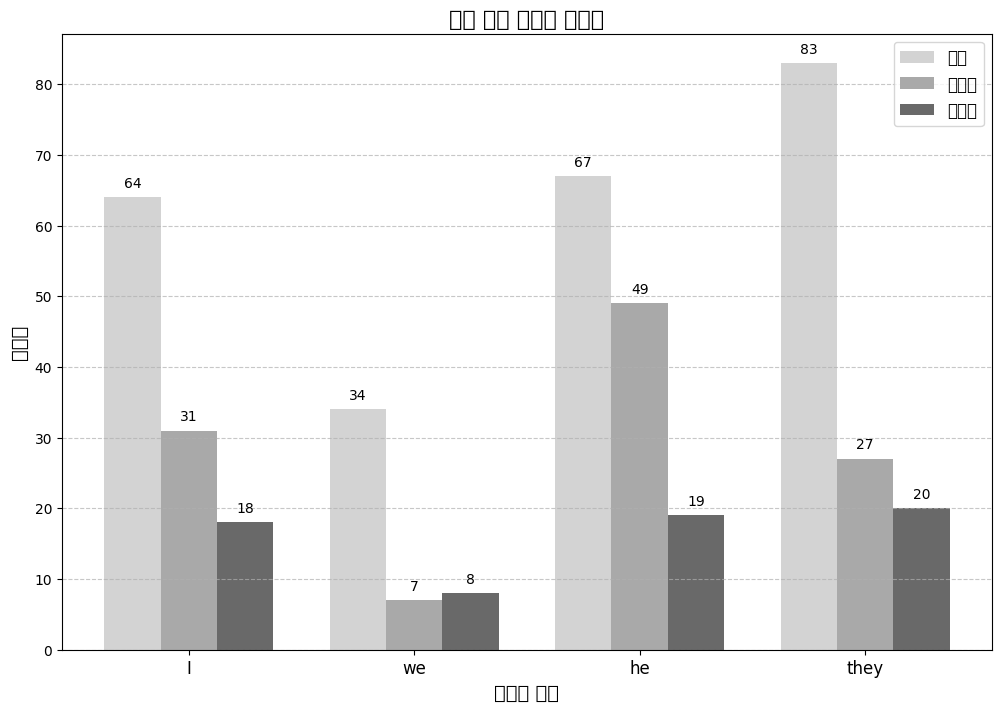

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# 대명사 유형과 각 형태의 빈도 데이터 정의
pronouns = ['I', 'we', 'he', 'they']
nominative = [64, 34, 67, 83]     # 주격
possessives = [31, 7, 49, 27]   # 소유격
accusative = [18, 8, 19, 20]        # 목적격

# 막대의 위치 및 너비 설정
x = np.arange(len(pronouns))  # 대명사 유형의 인덱스
width = 0.25  # 막대 너비

# 그래프 크기 설정
plt.figure(figsize=(12, 8))

# 각 형태별 막대 생성 (회색 계열)
plt.bar(x - width, subjects, width, label='주격', color='#d3d3d3')       # 밝은 회색
plt.bar(x, possessives, width, label='소유격', color='#a9a9a9')      # 중간 회색
plt.bar(x + width, objects, width, label='목적격', color='#696969')       # 어두운 회색

# 축 레이블 및 제목 추가
plt.xlabel('대명사 종류', fontsize=14)
plt.ylabel('빈도수', fontsize=14)
plt.title('격에 따른 대명사 빈도수', fontsize=16)

# x축의 대명사 유형 위치 설정
plt.xticks(x, pronouns, fontsize=12)

# 범례 추가
plt.legend(fontsize=12)

# 막대 위에 빈도 수 표시
for idx in range(len(pronouns)):
    plt.text(x[idx] - width, subjects[idx] + 1, subjects[idx], ha='center', va='bottom', fontsize=10)
    plt.text(x[idx], possessives[idx] + 1, possessives[idx], ha='center', va='bottom', fontsize=10)
    plt.text(x[idx] + width, objects[idx] + 1, objects[idx], ha='center', va='bottom', fontsize=10)

# 그리드 추가 (선택 사항)
plt.grid(axis='y', linestyle='--', alpha=0.7)


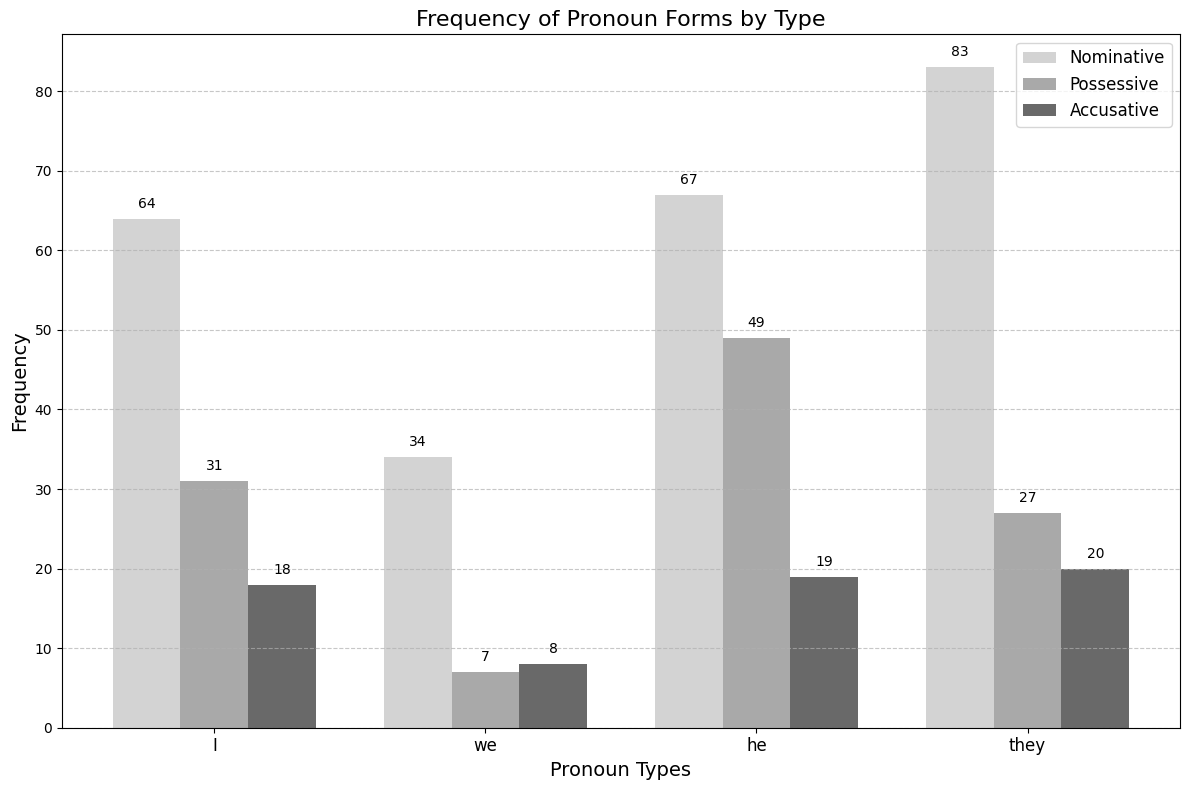

<Figure size 640x480 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# 대명사 유형과 각 형태의 빈도 데이터 정의
pronouns = ['I', 'we', 'he', 'they']
nominative = [64, 34, 67, 83]     # 주격
possessives = [31, 7, 49, 27]   # 소유격
accusative = [18, 8, 19, 20]        # 목적격

# 막대의 위치 및 너비 설정
x = np.arange(len(pronouns))  # 대명사 유형의 인덱스
width = 0.25  # 막대 너비

# 그래프 크기 설정
plt.figure(figsize=(12, 8))

# 각 형태별 막대 생성 (회색 계열)
plt.bar(x - width, subjects, width, label='Nominative', color='#d3d3d3')       # 밝은 회색
plt.bar(x, possessives, width, label='Possessive', color='#a9a9a9')      # 중간 회색
plt.bar(x + width, objects, width, label='Accusative', color='#696969')       # 어두운 회색

# 축 레이블 및 제목 추가
plt.xlabel('Pronoun Types', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Frequency of Pronoun Forms by Type', fontsize=16)

# x축의 대명사 유형 위치 설정
plt.xticks(x, pronouns, fontsize=12)

# 범례 추가
plt.legend(fontsize=12)

# 막대 위에 빈도 수 표시
for idx in range(len(pronouns)):
    plt.text(x[idx] - width, subjects[idx] + 1, subjects[idx], ha='center', va='bottom', fontsize=10)
    plt.text(x[idx], possessives[idx] + 1, possessives[idx], ha='center', va='bottom', fontsize=10)
    plt.text(x[idx] + width, objects[idx] + 1, objects[idx], ha='center', va='bottom', fontsize=10)

# 그리드 추가 (선택 사항)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 그래프 레이아웃 조정
plt.tight_layout()

# 그래프 출력
plt.show()

# 그래프를 파일로 저장하려면 다음 줄의 주석을 해제하세요.
plt.savefig('pronoun_frequency_gray.png', dpi=300)

In [21]:
# Define the specific words you want to count
specific_words_femsubj = ['mama', 'sister']

# Filter the tokens to include only the specific words
filtered_tokens_femsubj = [word for word in tokens if word in specific_words_femsubj ]

# Count the number of occurrences of the specific words
count_specific_words_femsubj = len(filtered_tokens_femsubj)
# Output the count
print(f"Count of specific words_femsubj 'mama & sister': {count_specific_words_femsubj}")



# Define the specific words you want to count
specific_words_malesubj = ['papa','brother']

# Filter the tokens to include only the specific words
filtered_tokens_malesubj = [word for word in tokens if word in specific_words_malesubj ]

# Count the number of occurrences of the specific words
count_specific_words_malesubj = len(filtered_tokens_malesubj)
# Output the count
print(f"Count of specific words_malesubj 'papa & brother': {count_specific_words_malesubj}")

Count of specific words_femsubj 'mama & sister': 235
Count of specific words_malesubj 'papa & brother': 225


In [ ]:
#Subject
# Define the specific words you want to count
specific_words_I_we = ['i', 'we']

# Filter the tokens to include only the specific words
filtered_tokens_I_we = [word for word in tokens if word in specific_words_I_we]

# Count the number of occurrences of the specific words
count_specific_words_I_we = len(filtered_tokens_I_we)

# Output the count
print(f"Count of specific words_I_we: {count_specific_words_I_we}")

print('\n')
#Possessive
# Define the specific words you want to count
specific_words_my_our = ['my', 'our']

# Filter the tokens to include only the specific words
filtered_tokens_my_our = [word for word in tokens if word in specific_words_my_our]

# Count the number of occurrences of the specific words
count_specific_words_my_our = len(filtered_tokens_my_our)

# Output the count
print(f"Count of specific words_my_our: {count_specific_words_my_our}")

print('\n')
#Object

# Define the specific words you want to count
specific_words_me_us = ['me', 'us']

# Filter the tokens to include only the specific words
filtered_tokens_me_us = [word for word in tokens if word in specific_words_me_us]

# Count the number of occurrences of the specific words
count_specific_words_me_us = len(filtered_tokens_me_us)

# Output the count
print(f"Count of specific words_me_us: {count_specific_words_me_us}")

# Define the specific words you want to count
specific_words_myself_ourselves = ['myself', 'ourselves']

# Filter the tokens to include only the specific words
filtered_tokens_myself_ourselves = [word for word in tokens if word in specific_words_myself_ourselves]

# Count the number of occurrences of the specific words
count_specific_words_myself_ourselves = len(filtered_tokens_myself_ourselves)

# Output the count
print(f"Count of specific words_myself_ourselves: {count_specific_words_myself_ourselves}")

Count of specific words_I_we: 98


Count of specific words_my_our: 38


Count of specific words_me_us: 26
Count of specific words_myself_ourselves: 0


In [ ]:
# Define the specific words you want to count
specific_words_allreflexive = ['myself', 'yourself', 'himself', 'herself', 'itself', 'ourselves', 'yourselves', 'ourselves', 'themselves']

# Filter the tokens to include only the specific words
filtered_tokens_allreflexive = [word for word in tokens if word in specific_words_allreflexive]

# Count the number of occurrences of the specific words
count_specific_words_allreflexive = len(filtered_tokens_allreflexive)

# Output the count
print(f"Count of specific words_allreflexive: {count_specific_words_allreflexive}")

Count of specific words_allreflexive: 2


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!




<Text: ﻿text_column `` down a sunny dirt road ,...>
Displaying 20 of 94 matches:
y about that , small bear , ” said mama bear as she closed the door after him . she smiled and patt
id mama bear as she closed the door after him . she smiled and patted her front , which had lately 
ew baby sister . and now he was a big brother ! she was very little but very lively . as small bear
 as small bear learned over for a closer look , she popped him on the nose with a tiny fist . “ hmm
ith a tiny fist . “ hmm , ” said small bear . “ she has a pretty good punch for a little baby. ” th
sed brother . “ of course not , ” said sister . she left her book on the floor and climbed onto the
fingers in her ears . “ that ’ s enough ! ” and she went back to her storybook . “ scaredy bear ! s
e—it gave her quite a scare . “ mama ! papa ! ” she cried . “ hurry ! come quick ! ” and come quick
tubbed . and mama was looking for the night cap she had lost in the confusion . all three of them w
 with me , ” he s

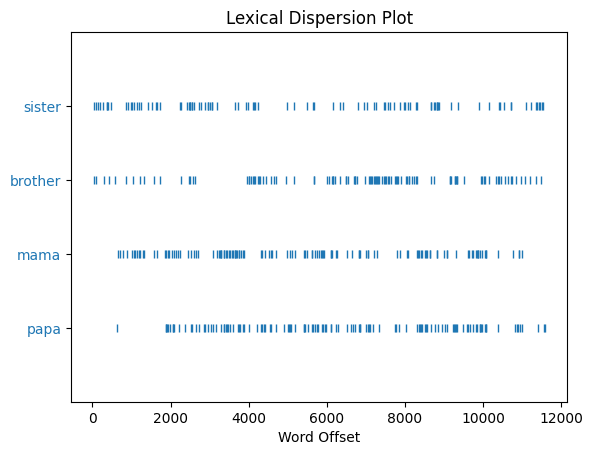

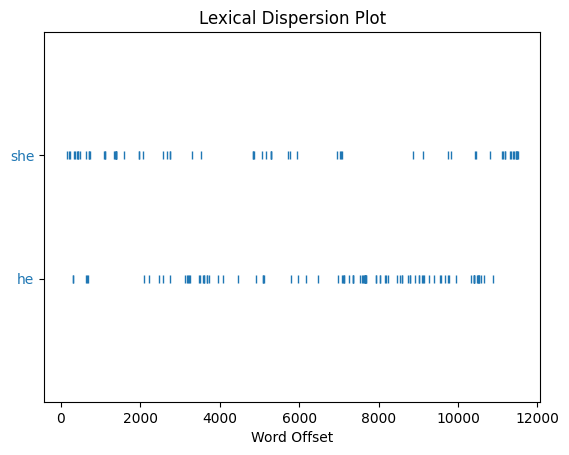

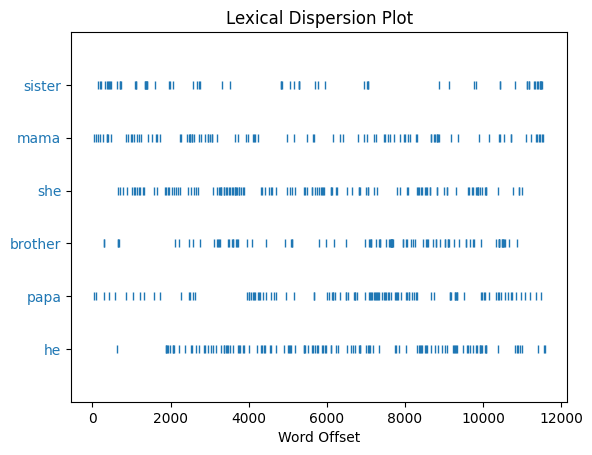

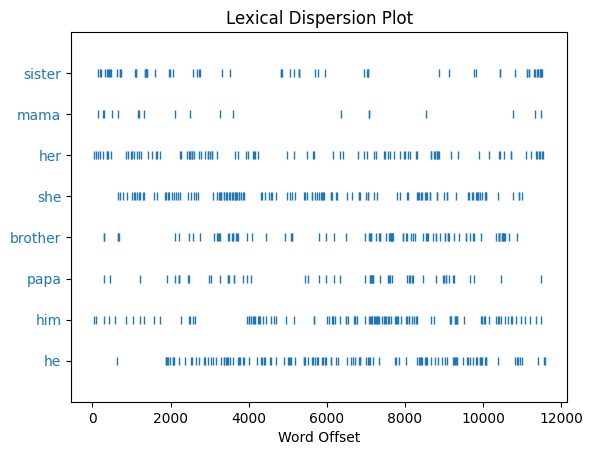

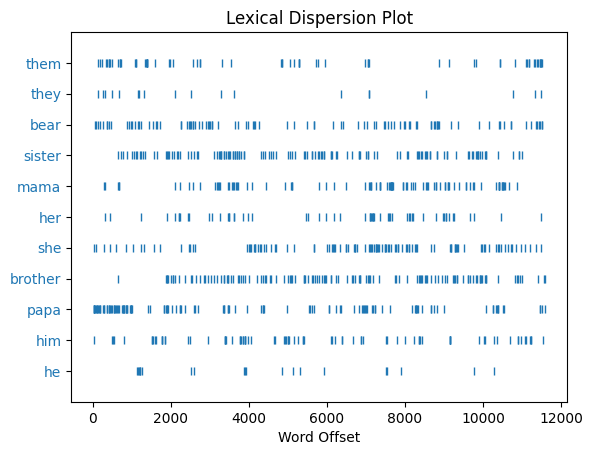

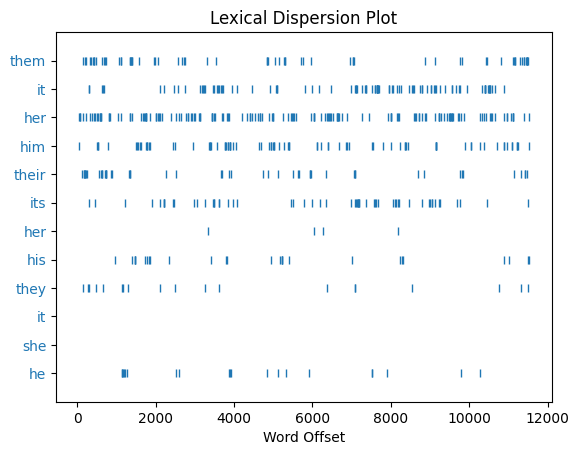

In [ ]:
!pip install nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.text import Text

nltk.download('punkt') # Download the punkt tokenizer data

#Step 1: Tokenize the text
tokens = word_tokenize(text.lower())  # Tokenize the text and convert to lowercase

# Step 2: Create an NLTK Text object from the list of words.
text_object = nltk.Text(tokens)
print('\n')
print(text_object)

# Step 3: Find and print collocations (this automatically finds frequent word pairs)
#print(text_object.collocations()) #not working as of 24SEP24
#print('\n')

# Step 4: Display a concordance for the word 'Emma'
text_object.concordance('she', width=100, lines=20)
print('\n')

# Step 5: Plotting
text_object.dispersion_plot(['papa', 'mama', 'brother', 'sister'])

print('\n')
text_object.dispersion_plot(['he', 'she'])
print('\n')
text_object.dispersion_plot(['he', 'papa', 'brother', 'she', 'mama', 'sister'])
print('\n')
text_object.dispersion_plot(['he', 'him', 'papa', 'brother', 'she', 'her', 'mama', 'sister'])
print('\n')
text_object.dispersion_plot(['he', 'him', 'papa', 'brother', 'she', 'her', 'mama', 'sister', 'bear', 'they', 'them'])
print('\n')
text_object.dispersion_plot(['he', 'she', 'it', 'they', 'his', 'her', 'its', 'their', 'him', 'her', 'it', 'them'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!




<Text: ﻿text_column `` sunny dirt road , log bridge...>
Displaying 20 of 121 matches:
nny dirt road , log bridge , grassy hill , deep bear country , lived family bears—papa bear , mama b
l , deep bear country , lived family bears—papa bear , mama bear small bear . lived large tree papa 
r country , lived family bears—papa bear , mama bear small bear . lived large tree papa bear hollowe
 lived family bears—papa bear , mama bear small bear . lived large tree papa bear hollowed made hous
 , mama bear small bear . lived large tree papa bear hollowed made house . fine house . looked like 
. fine house . looked like inside . fun growing bear country ... helping papa get honey old bee tree
etables garden . sorts interesting things small bear see bear-country . small bear felt good growing
ting things small bear see bear-country . small bear felt good growing tree ... room ... snug little
 growing tree ... room ... snug little bed papa bear made baby . one morning , feel good . small bea
ear

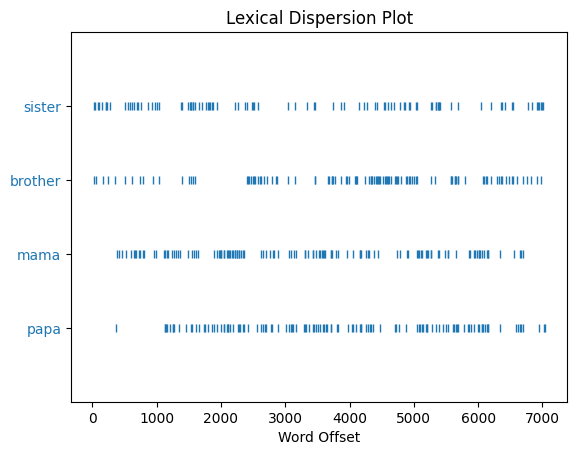

In [ ]:
!pip install nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.text import Text

nltk.download('punkt') # Download the punkt tokenizer data

stopwords =  [ 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't",'wouldn', "wouldn't" ]

#Step 1: Tokenize the text
tokens = word_tokenize(text.lower())  # Tokenize the text and convert to lowercase
words = [word for word in tokens if word not in stopwords]

# Step 2: Create an NLTK Text object from the list of words.
text_object = nltk.Text(words)
print('\n')
print(text_object)

# Step 3: Find and print collocations (this automatically finds frequent word pairs)
#print(text_object.collocations()) #not working as of 24SEP24
#print('\n')

# Step 4: Display a concordance for the word 'Emma'
text_object.concordance('bear', width=100, lines=20)
print('\n')

# Step 5: Plotting
text_object.dispersion_plot(['papa', 'mama', 'brother', 'sister'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!




<Text: ﻿text_column `` sunny dirt road , log bridge...>
tree house; small bear; bear family; bear country; said papa; sunny
dirt; dirt road; said mama; vegetable patch; little bed; grizzly bob;
said sister; said brother; silly goose; brother sister; case crying;
common sense; wing tips; wanted know; name calling
None


Displaying 20 of 127 matches:
wn snug little bed time new baby sister . big brother ! little lively . small bear learned closer l
d proudly bigger bed . “ aah ! ” said . “ big brother going fun. ” next morning woke feeling fine ,
nny dirt road deep bear country . years ago , brother bear cub , lived hillside cave halfway great 
a bear plenty wood cutting furniture making . brother bear kept busy climbing , collecting rocks , 
 dears , time come move. ” “ move ! ? ” cried brother bear . “ ’ right , ” said papa . “ trees gett
 family thin , rocky soil. ” “ going move ? ” brother asked . “ valley , ” said papa began putting 
 putting lamps things box . “ valley ? ” said b

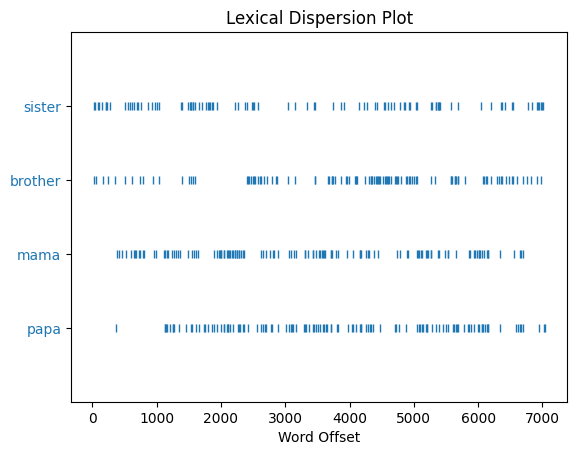

In [ ]:
!pip install nltk
import nltk
from nltk.tokenize import word_tokenize
from nltk.text import Text

nltk.download('punkt') # Download the punkt tokenizer data

stopwords =  [ 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't",'wouldn', "wouldn't" ]

#Step 1: Tokenize the text
tokens = word_tokenize(text.lower())  # Tokenize the text and convert to lowercase
words = [word for word in tokens if word not in stopwords]

# Step 2: Create an NLTK Text object from the list of words.
text_object = nltk.Text(words)
print('\n')
print(text_object)

# Step 3: Find and print collocations (this automatically finds frequent word pairs)
print(text_object.collocations())
print('\n')

# Step 4: Display a concordance for the word 'Emma'
text_object.concordance('brother', width=100, lines=20)
print('\n')

# Step 5: Plotting
text_object.dispersion_plot(['papa', 'mama', 'brother', 'sister'])


Polarity and Subjectivity (from ChatGPT)
Interpretation

Polarity: 0.131
>
Interpretation: The polarity score of 0.136 suggests that the text has a slightly positive sentiment, but it's not strongly positive. This means the emotions expressed in the text lean toward the positive side, but the overall tone is fairly neutral with just a mild positive inclination.
Range Context:
Polarity scores close to 1 would indicate very positive sentiment.
Scores close to -1 would indicate strong negative sentiment.
A score around 0 would indicate neutral sentiment.
In this case, 0.136 shows a moderately positive sentiment, perhaps expressing mild approval or contentment.
>

Subjectivity: 0.515
>
Interpretation: The subjectivity score of 0.518 indicates that the text is slightly more subjective than objective. This suggests that the text contains a balance between personal opinions, emotions, or beliefs and factual or objective statements, but it leans a little toward subjective (opinion-based) content.
Range Context:
Scores closer to 1 suggest the text is highly subjective (mainly personal opinions or emotions).
Scores closer to 0 suggest the text is highly objective (based on facts or verifiable information).
A score of 0.518 suggests that the text likely contains a mix of subjective opinions and factual information but is more on the subjective side.
Overall Interpretation:
The text analyzed is slightly positive in tone (mild positive sentiment) and contains a balance of opinions and facts, but with a small tilt toward subjectivity. It likely expresses some personal feelings or opinions, though not overwhelmingly so, and doesn't contain strong emotional language.

Would you like to analyze more texts, or need clarification on these concepts?

In [ ]:
# Install TextBlob if not already installed
!pip install textblob
from textblob import TextBlob

# Perform sentiment analysis
blob = TextBlob(text)
sentiment = blob.sentiment

# Print sentiment polarity and subjectivity
print(f"Polarity: {sentiment.polarity}, Subjectivity: {sentiment.subjectivity}")

#극성과 주관성
#positive emotions (e.g., happiness, excitement); negative emotions (e.g., sadness, anger); emotional neutral
#personal opinions, feelings, or subjective judgments; objective, based on facts or verifiable information.

Polarity: 0.13106612614353377, Subjectivity: 0.5150985481080272


1. Named Entity Recognition (NER)
Identify and categorize entities such as characters, locations, and organizations. For children's books like The Berenstain Bears, NER can help recognize characters and places.

Python Code for NER (using spaCy):

-> This need restarting colab and I did not follow its alert message. The results seem not very helpful

In [ ]:
#BOMB
!pip install spacy
!python -m spacy download en_core_web_sm  # Download a small English model
import spacy

# Load the pre-trained spaCy model
nlp = spacy.load("en_core_web_sm")


# Apply the spaCy NLP pipeline to the text
doc = nlp(text)

# Print named entities found in the text
for entity in doc.ents:
    print(entity.text, entity.label_)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 47.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Bear Country ORG
Papa Bear ORG
Bear Country ORG
Papa ORG
Bear-Country ORG
Papa Bear ORG
one morning TIME
Papa Bear PERSON
Today DATE
Papa PERSON
Small Bear ORG
Small Bear PERSON
Mama Bear PERSON
Papa Bear ORG
Papa ORG
Bear ORG
Small Bear PERSON
Mama Bear PERSON
Papa Bear PERSON
the day DATE
Small Bear ORG
Small Bear PERSON
Mama Bear PERSON
Small Bear PERSON
Hmm PERSON
Small Bear PERSON
That night TIME
The next morning TIME
The Bear WORK_OF_ART
Bear Country ORG
Years ago DATE
Brother Bear ORG
Great Bear Mountain FAC
Bear Country ORG
summer DATE
winter DATE
Bear PERSON
Papa Bear

Bigram/Trigram Analysis

In [ ]:
!pip install nltk
import nltk
nltk.download('punkt') # Download the punkt tokenizer data
from nltk.tokenize import word_tokenize
from nltk.text import Text
from collections import Counter

stopwords =  [ 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't",'wouldn', "wouldn't" ]

#Step 1: Tokenize the text
tokens = word_tokenize(text.lower())  # Tokenize the text and convert to lowercase
words = [word for word in tokens if word not in stopwords]

# Step 2: Create an NLTK Text object from the list of words.
text_object = nltk.Text(words)

# Count word frequencies
word_freq = Counter(text_object)

# Print the most common words
print(word_freq.most_common(50))  # Top 50 most common words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('.', 583), (',', 480), ('“', 350), ('”', 345), ('’', 242), ('!', 170), ('brother', 127), ('said', 125), ('sister', 125), ('bear', 121), ('mama', 110), ('papa', 98), ('?', 64), ('cubs', 37), ('one', 34), ('family', 33), ('little', 33), ('...', 32), ('big', 30), ('tree', 29), ('like', 29), ('day', 27), ('house', 26), ('time', 25), ('asked', 25), ('got', 23), ('good', 22), ('would', 20), ('night', 18), ('small', 17), ('get', 17), ('things', 17), ('bed', 17), ('even', 17), ('``', 16), ('made', 16), ('going', 16), ('cave', 16), ('quite', 16), ('looked', 15), ('old', 15), ('look', 15), ('began', 15), ('know', 15), ('well', 15), ('country', 14), ('fine', 14), ('back', 14), ('right', 14), ('camp', 14)]


In [ ]:
!pip install nltk
import nltk
from nltk import ngrams
from nltk.tokenize import word_tokenize

# Tokenize the text
tokens = word_tokenize(text.lower())

# Generate bigrams (two-word combinations)
bigrams = list(ngrams(tokens, 2))

# Generate trigrams (three-word combinations)
trigrams = list(ngrams(tokens, 3))

# Print bigrams
print("Bigrams:")
for bigram in bigrams:
    print(bigram)

# Print trigrams
print("\nTrigrams:")
for trigram in trigrams:
    print(trigram)

Streaming output truncated to the last 5000 lines.
('just', 'maybe', ',')
('maybe', ',', 'my')
(',', 'my', 'cubs')
('my', 'cubs', ',')
('cubs', ',', 'whom')
(',', 'whom', 'i')
('whom', 'i', '’')
('i', '’', 've')
('’', 've', 'always')
('ve', 'always', 'trusted')
('always', 'trusted', ',')
('trusted', ',', 'aren')
(',', 'aren', '’')
('aren', '’', 't')
('’', 't', 'telling')
('t', 'telling', 'me')
('telling', 'me', 'the')
('me', 'the', 'truth')
('the', 'truth', '.')
('truth', '.', 'and')
('.', 'and', 'trust')
('and', 'trust', 'is')
('trust', 'is', 'not')
('is', 'not', 'something')
('not', 'something', 'you')
('something', 'you', 'can')
('you', 'can', 'put')
('can', 'put', 'back')
('put', 'back', 'together')
('back', 'together', 'again.')
('together', 'again.', '”')
('again.', '”', 'both')
('”', 'both', 'cubs')
('both', 'cubs', 'started')
('cubs', 'started', 'to')
('started', 'to', 'talk')
('to', 'talk', 'at')
('talk', 'at', 'once')
('at', 'once', '.')
('once', '.', '“')
('.', '“', 'it')
('

BOMB
Summary (not working)

In [ ]:
#@markdown <font color = 'red'> Summary suggested by ChatGPT not working!

!pip install nltk
import nltk
nltk.download('punkt') # Download the punkt tokenizer data
from nltk.tokenize import word_tokenize
from nltk.text import Text

!pip install transformers
!pip install torch
from transformers import pipeline

# Load the summarization pipeline
summarizer = pipeline("summarization")
# Generate the summary
summary = summarizer(text, max_length=50, min_length=25, do_sample=False)

# Print the summary
print(summary[0]['summary_text'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (13267 > 1024). Running this sequence through the model will result in indexing errors


IndexError: index out of range in self

##💯 Before you proceed...
You can write the regular expression pattern as <font color = 'red'> either</font> **RegexpTokenizer("[\w]+"), <font color = 'red'> either</font> **RegexpTokenizer("\w+"), <font color = 'red'> either</font> **RegexpTokenizer(r"\w+")** <font color = 'red'>or</font> **RegexpTokenizer(r"[\w]+")**. <font color = 'blue'> The 'r' before the string denotes a raw string literal, which is often used with regular expressions to avoid issues with escape characters.

The regular expression [\w]+ breaks down as follows:

- **\w** shorthand character class, which represents word characters "a-zA-Z0-9".
- [ ] matches any single character specified in a pair of the square brackets.
- **[\w]**: Match any word character (equivalent to [a-zA-Z0-9_]).
- **+**: Match one or more occurrences of the preceding character class.
- So, **[\w]+** will match one or more consecutive word characters, effectively tokenizing text into words.
>
🆘 If you remove the square brackets and use \w+ (without [ ]), it would still work the same way, as \w+ is a shorthand for "match one or more word characters." The square brackets, in this case, are redundant but can be used for clarity or when you want to match a specific set of characters.
>
🆘 The 'r' before the string (as in r"[\w]+") is optional in this case but is a good practice, especially with regular expressions, to avoid unintended escape character interpretation. It tells Python to treat the string as a "raw string," where backslashes are treated literally and not as escape characters.

In [ ]:
from nltk.tokenize import RegexpTokenizer
# Create a RegexpTokenizer with the pattern [\w]+
retokenize = RegexpTokenizer("[\w]+")
# Tokenize the text using the regular expression pattern
words = retokenize.tokenize(text)

### 🔴 ⚪ 🔵 Normalization  
Stemming: am → am, having → hav  
Lemmatization: am → be, having → have

### <font color = 'red'> **Student Activity** 1️⃣
- Examine the tokens listed in the result and understand how words are tokenized with **Poterstemmer()** function.⤵️

In [ ]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
[stemmer.stem(w) for w in words]

['down',
 'a',
 'sunni',
 'dirt',
 'road',
 'over',
 'a',
 'log',
 'bridg',
 'up',
 'a',
 'grassi',
 'hill',
 'deep',
 'in',
 'bear',
 'countri',
 'live',
 'a',
 'famili',
 'of',
 'bear',
 'papa',
 'bear',
 'mama',
 'bear',
 'and',
 'small',
 'bear',
 'they',
 'live',
 'in',
 'a',
 'larg',
 'tree',
 'which',
 'papa',
 'bear',
 'had',
 'hollow',
 'out',
 'and',
 'made',
 'into',
 'a',
 'hous',
 'it',
 'wa',
 'a',
 'veri',
 'fine',
 'hous',
 'thi',
 'is',
 'what',
 'it',
 'look',
 'like',
 'insid',
 'it',
 'wa',
 'fun',
 'grow',
 'up',
 'in',
 'bear',
 'countri',
 'help',
 'papa',
 'get',
 'honey',
 'from',
 'the',
 'old',
 'bee',
 'tree',
 'help',
 'mama',
 'bring',
 'the',
 'veget',
 'in',
 'from',
 'the',
 'garden',
 'there',
 'were',
 'all',
 'sort',
 'of',
 'interest',
 'thing',
 'for',
 'a',
 'small',
 'bear',
 'to',
 'do',
 'and',
 'see',
 'in',
 'bear',
 'countri',
 'small',
 'bear',
 'felt',
 'good',
 'grow',
 'up',
 'in',
 'a',
 'tree',
 'in',
 'hi',
 'own',
 'room',
 'in',
 't

### <font color = 'red'> **Student Activity** 2️⃣
- Examine the tokens listed in the result and understand how words are tokenized with **LancasterStemmer()** function.⤵️

In [ ]:
#from nltk.stem import LancasterStemmer
#stemmer = LancasterStemmer()
#[stemmer.stem(w) for w in words]

### <font color = 'red'> **Student Activity** 3️⃣
- Examine the tokens listed in the result and understand how words are tokenized with **WordNetLemmatizer()** function.⤵️

In [ ]:
#from nltk.stem import WordNetLemmatizer
#nltk.download('wordnet')
#lemmatizer = WordNetLemmatizer()
#[lemmatizer.lemmatize(w) for w in words]

### ⛔ <font color = 'brown'> **Stopword**

✏️ In natural language processing, stop words are commonly used words (e.g., "the," "and," "is") that are often filtered out because they don't contribute much to the meaning of a text. Here's an example list of English stop words:

stopwords = [ 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't",'wouldn', "wouldn't" ]

You can customize or extend this list based on your specific needs and the requirements of your natural language processing task. Keep in mind that the appropriateness of stop words may vary depending on the specific context and analysis you are conducting.

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')
print(words)
words = [w for w in words if not w in stopwords.words('english')]
print(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['Down', 'a', 'sunny', 'dirt', 'road', 'over', 'a', 'log', 'bridge', 'up', 'a', 'grassy', 'hill', 'deep', 'in', 'Bear', 'Country', 'lived', 'a', 'family', 'of', 'bears', 'Papa', 'Bear', 'Mama', 'Bear', 'and', 'Small', 'Bear', 'They', 'lived', 'in', 'a', 'large', 'tree', 'which', 'Papa', 'Bear', 'had', 'hollowed', 'out', 'and', 'made', 'into', 'a', 'house', 'It', 'was', 'a', 'very', 'fine', 'house', 'This', 'is', 'what', 'it', 'looked', 'like', 'inside', 'It', 'was', 'fun', 'growing', 'up', 'in', 'Bear', 'Country', 'helping', 'Papa', 'get', 'honey', 'from', 'the', 'old', 'bee', 'tree', 'helping', 'Mama', 'bring', 'the', 'vegetables', 'in', 'from', 'the', 'garden', 'There', 'were', 'all', 'sorts', 'of', 'interesting', 'things', 'for', 'a', 'small', 'bear', 'to', 'do', 'and', 'see', 'in', 'Bear', 'Country', 'Small', 'Bear', 'felt', 'good', 'growing', 'up', 'in', 'a', 'tree', 'in', 'his', 'own', 'room', 'in', 'the', 'snug', 'little', 'bed', 'that', 'Papa', 'Bear', 'had', 'made', 'for', 'hi

### 📍 Collocation 📍Concordance

In [ ]:
#!pip install nltk
#import nltk
#from nltk.tokenize import word_tokenize

# Download the Gutenberg corpus
#nltk.download('gutenberg')
# Load the text from 'austen-emma.txt'
#text = nltk.corpus.gutenberg.raw('austen-emma.txt')

# Create a RegexpTokenizer
#import re
#from nltk.tokenize import RegexpTokenizer
#retokenize = RegexpTokenizer(r"[\w]+")
# Tokenize the text using the regular expression pattern
#words = retokenize.tokenize(text)

# Print the first 50 words as an example
#print(words[:50])

Before you proceed...

In NLTK (Natural Language Toolkit), the **Text class** is part of the nltk.text module. The Text class is designed to work with a sequence of words and provides several methods for exploring and analyzing text data. It is often used to represent and analyze corpora or individual texts.

In [ ]:
# Create an NLTK Text object from the list of words.
text_object = nltk.Text(words)

🆘 <font color = 'blue'> **Collocations** (연어) are pairs of words that occur together frequently in a given context.

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


tree house; bear family; small bear; bear country; said papa; sunny
dirt; said mama; dirt road; said sister; said brother; little bed;
vegetable patch; grizzly bob; silly goose; common sense; wing tips;
sister bear; name calling; radio-controlled job; skull rock
None
Displaying 20 of 125 matches:
 snug little bed just in time for his new baby sister . and now he was a big brother ! she was very 
t about perfect. `` `` “ brother bear , ” said sister impatiently , “ are you going to take all day 
u going to take all day to pick your books ? ” sister and brother bear at the bear country library .
and brother bear at the bear country library . sister had already chosen her books and was waiting a
brother . “ i am looking for a good mystery. ” sister bear usually took out storybooks and books abo
 “ okay , let ’ s check out. ” “ hmmm , ” said sister , looking at the cover . it was called the cas
uld you like me to read it to you ? ” he asked sister . sister was looking at a storybook about 

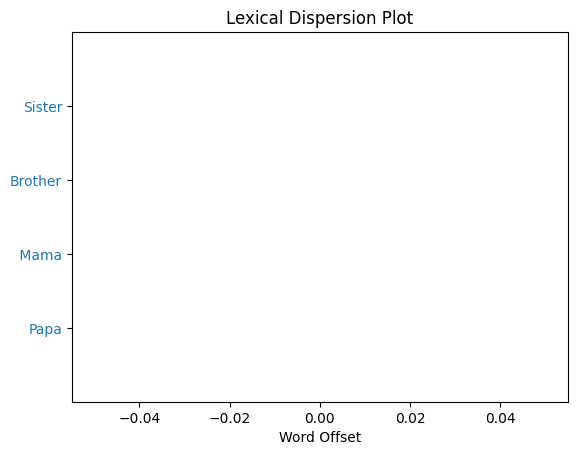

In [ ]:
!pip install nltk
import nltk
from nltk.text import Text
from nltk.tokenize import word_tokenize

nltk.download('punkt')

# Download the stopwords resource
#nltk.download('stopwords')
#nltk.download('genesis') #I don't know this codeline exactly.

# Step 1: Tokenize the text
tokens = word_tokenize(text.lower())  # Tokenize the text and convert to lowercase

# Step 2: Create an NLTK Text object
text_object = Text(tokens)

# Step 3: Find and print collocations (this automatically finds frequent word pairs)
print(text_object.collocations())

# Step 4: Display a concordance for the word 'Emma'
text_object.concordance('Sister', width=100, lines=20)

# Step 5: Plotting
text_object.dispersion_plot(['Papa', ' Mama', 'Brother', 'Sister'])


🆘 <font color = 'blue'> **Concordance** (용례) shows the context in which a word appears in the text

In [ ]:
!pip install nltk
import nltk
from nltk.text import Text
from nltk.tokenize import word_tokenize

nltk.download('punkt')

# Download the stopwords resource
#nltk.download('stopwords')
#nltk.download('genesis') #I don't know this codeline exactly.

# Step 1: Tokenize the text
tokens = word_tokenize(text.lower())  # Tokenize the text and convert to lowercase

# Step 2: Create an NLTK Text object
text_object = Text(tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Display a concordance for the word 'Emma'
text_object.concordance('Sister', width=100, lines=20)

Displaying 20 of 125 matches:
 snug little bed just in time for his new baby sister . and now he was a big brother ! she was very 
t about perfect. `` `` “ brother bear , ” said sister impatiently , “ are you going to take all day 
u going to take all day to pick your books ? ” sister and brother bear at the bear country library .
and brother bear at the bear country library . sister had already chosen her books and was waiting a
brother . “ i am looking for a good mystery. ” sister bear usually took out storybooks and books abo
 “ okay , let ’ s check out. ” “ hmmm , ” said sister , looking at the cover . it was called the cas
uld you like me to read it to you ? ” he asked sister . sister was looking at a storybook about thre
ike me to read it to you ? ” he asked sister . sister was looking at a storybook about three kittens
 ? ” teased brother . “ of course not , ” said sister . she left her book on the floor and climbed o
ession . “ ’ who-o-o-o-o ! ’ ” “ stop ! ” said sister , putti

In [ ]:
#@markdown 🐹 🐾 <font color = 'green'> **This code cell is repeated, referring to code cells from [7] to [10] right above.**

!pip install nltk
import nltk
from nltk.tokenize import word_tokenize

# Download the Gutenberg corpus
nltk.download('gutenberg')
# Load the text from 'austen-emma.txt'
text = nltk.corpus.gutenberg.raw('austen-emma.txt')

# Create a RegexpTokenizer
import re
from nltk.tokenize import RegexpTokenizer
retokenize = RegexpTokenizer(r"[\w]+")
# Tokenize the text using the regular expression pattern
words = retokenize.tokenize(text)

# Create an NLTK Text object from the list of words.
text_object = nltk.Text(words)

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


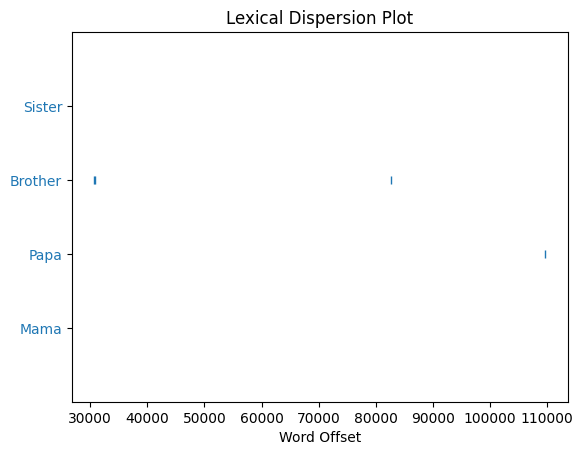

In [ ]:
# Generate a dispersion plot (분산도) for the specified words
text_object.dispersion_plot(["Mama","Papa","Brother", "Sister"])

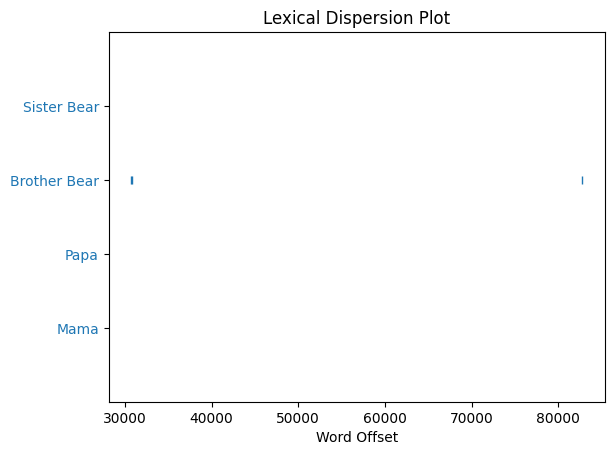

In [ ]:
# Generate a dispersion plot (분산도) for the specified words
text_object.dispersion_plot(["Mama", "Papa", "Brother Bear", "Sister Bear"])

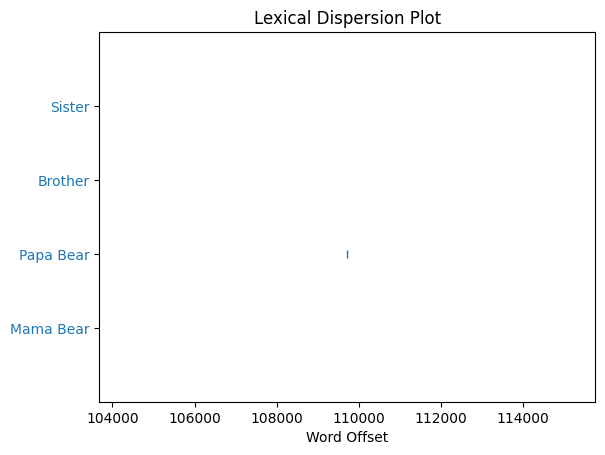

In [ ]:
# Generate a dispersion plot (분산도) for the specified words
text_object.dispersion_plot(["Mama Bear","Papa Bear","Brother", "Sister"])

###⛔ **Befoe you proceed...**
- The similar() method in NLTK's Text class is used to find _words_ that appear _in a similar context to the specified word_. It helps identify words that tend to occur in similar contexts within the given text.

In [ ]:
#Finds words that appear in a similar context to "Emma."
text_object.similar("Emma")

she it he i harriet you her jane him that me and all they them herself
there but be isabella


###🚫 **Befoe you proceed...**
- The common_contexts() method in NLTK's Text class is used to display contexts shared by two or more words. It helps identify situations where specific words appear together in similar contexts.

###- How to interpret the result?
    - said_i and_could: In contexts where "said" is followed by "I" and "could."
    - but_could said_as and_was: In contexts where "but" is followed by "could," "said as," and "was."
    - that_could said_in as_could: In contexts where "that" is followed by "could," "said in," and "as could," and so on.

In [ ]:
nltk.Text(words).common_contexts(["Emma", "she"])

said_i and_could but_could said_as and_was that_could and_felt
which_could that_began than_had but_was that_should this_could
there_was said_in as_could think_was as_felt that_was which_had


### Frequency distribution, Frequency plot

In [ ]:
# Create a frequency distribution of words and get the 20 most common words
fd = nltk.FreqDist(words).most_common(20)
# print the result by writing its variable name.
print(fd) # results as a list horizontally
fd # results as a list vertically

[('to', 5183), ('the', 4844), ('and', 4672), ('of', 4279), ('I', 3178), ('a', 3004), ('was', 2385), ('her', 2381), ('it', 2128), ('in', 2118), ('not', 2101), ('be', 1970), ('she', 1778), ('that', 1730), ('you', 1677), ('had', 1606), ('as', 1387), ('he', 1365), ('for', 1321), ('have', 1301)]


[('to', 5183),
 ('the', 4844),
 ('and', 4672),
 ('of', 4279),
 ('I', 3178),
 ('a', 3004),
 ('was', 2385),
 ('her', 2381),
 ('it', 2128),
 ('in', 2118),
 ('not', 2101),
 ('be', 1970),
 ('she', 1778),
 ('that', 1730),
 ('you', 1677),
 ('had', 1606),
 ('as', 1387),
 ('he', 1365),
 ('for', 1321),
 ('have', 1301)]

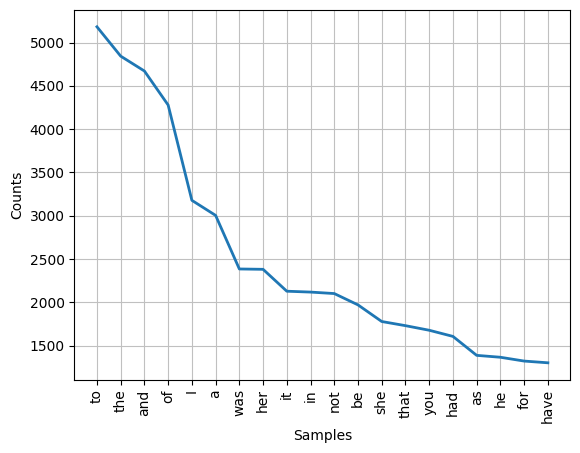

<Axes: xlabel='Samples', ylabel='Counts'>

In [ ]:
# Create an NLTK Text object and plot the frequency distribution of the 20 most common words
nltk.Text(words).plot(20)

### 📚<font color ='blue'> **Dictionary**

In [ ]:
# Download the 'words' corpus and display the last 20 words in the English language
nltk.download('words')
nltk.corpus.words.words('en')[-20:-1]

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


['zymosis',
 'zymosterol',
 'zymosthenic',
 'zymotechnic',
 'zymotechnical',
 'zymotechnics',
 'zymotechny',
 'zymotic',
 'zymotically',
 'zymotize',
 'zymotoxic',
 'zymurgy',
 'Zyrenian',
 'Zyrian',
 'Zyryan',
 'zythem',
 'Zythia',
 'zythum',
 'Zyzomys']

In [ ]:
# Get the total number of words in the English language corpus
len(nltk.corpus.words.words('en'))

235886

### ♊ Regular expression

In [ ]:
import re

In [ ]:
# Load the English words corpus
engdict = nltk.corpus.words.words('en')

# Filter words in the English dictionary that end with 'ed'
result = [w for w in engdict if re.search('ed$', w)]
# result = [w for w in engdict if re.search('^..j..t..$', w)]
# result = [w for w in engdict if re.search('^[ghi][mno][jlk][def]$', w)]
# result = [w for w in engdict if re.search('^[ah]+$', w)][:10]

# Print the first 10 words in the result list
print(result[:10])

['abaissed', 'abandoned', 'abased', 'abashed', 'abatised', 'abed', 'aborted', 'abridged', 'abscessed', 'absconded']


In [ ]:
#@markdown 🅿️ Additional exercise2 for RE. Check out the code line if you are interested...
result = [w for w in engdict if re.search('^[ghi][mno][jlk][def]$', w)]
print(result[:10])

['gold', 'golf', 'hold', 'hole']


In [ ]:
# Download the 'treebank' corpus
nltk.download('treebank')
# Load the words from the treebank corpus
wsj = nltk.corpus.treebank.words()

# Filter words in the treebank corpus that end with 'ed' or 'ing'
result = [w for w in wsj if re.search('(ed|ing)$', w)]

#If you are interested, play with the following RE.
# result = [w for w in wsj if re.search('^[0-9]+\.[0-9]+$', w)]
# result = [w for w in wsj if re.search('^[A-Z]+\$$', w)]
# result = [w for w in wsj if re.search('^[0-9]{4}$', w)]
# result = [w for w in wsj if re.search('^[0-9]+-[a-z]{3,5}$', w)]
# result = [w for w in wsj if re.search('^[a-z]{5,}-[a-z]{2,3}-[a-z]{,6}$', w)]

result = sorted(set(result))
print(result[:10])

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


['62%-owned', 'Absorbed', 'According', 'Adopting', 'Advanced', 'Advancing', 'Alfred', 'Allied', 'Annualized', 'Anything']


### 🔨🔧 Extract information (pos tag, named entity)

##💯 Before you proceed...

🐣The nltk.download('punkt') command is used to download the 'punkt' resource from the NLTK (Natural Language Toolkit) library.

🐣This resource includes the pre-trained Punkt tokenizer models **for tokenization**.

🐣Tokenization is the process of breaking down **a text into words or sentences**,vand the Punkt tokenizer is <font color = 'blue'>_a machine learning-based tokenization algorithm_ included in NLTK.

In [ ]:
!pip install nltk
import nltk
nltk.download('punkt')

# Example sentence and tokenization
sent = "I am Jhon from America and would like to go to Starbucks"
words = nltk.word_tokenize(sent)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
'''
POS tag list:

CC	coordinating conjunction
CD	cardinal digit
DT	determiner
EX	existential there (like: "there is" ... think of it like "there exists")
FW	foreign word
IN	preposition/subordinating conjunction
JJ	adjective	'big'
JJR	adjective, comparative	'bigger'
JJS	adjective, superlative	'biggest'
LS	list marker	1)
MD	modal	could, will
NN	noun, singular 'desk'
NNS	noun plural	'desks'
NNP	proper noun, singular	'Harrison'
NNPS	proper noun, plural	'Americans'
PDT	predeterminer	'all the kids'
POS	possessive ending	parent's
PRP	personal pronoun	I, he, she
PRP$	possessive pronoun	my, his, hers
RB	adverb	very, silently,
RBR	adverb, comparative	better
RBS	adverb, superlative	best
RP	particle	give up
TO	to	go 'to' the store.
UH	interjection	errrrrrrrm
VB	verb, base form	take
VBD	verb, past tense	took
VBG	verb, gerund/present participle	taking
VBN	verb, past participle	taken
VBP	verb, sing. present, non-3d	take
VBZ	verb, 3rd person sing. present	takes
WDT	wh-determiner	which
WP	wh-pronoun	who, what
WP$	possessive wh-pronoun	whose
WRB	wh-abverb	where, when
'''

'\nPOS tag list:\n\nCC\tcoordinating conjunction\nCD\tcardinal digit\nDT\tdeterminer\nEX\texistential there (like: "there is" ... think of it like "there exists")\nFW\tforeign word\nIN\tpreposition/subordinating conjunction\nJJ\tadjective\t\'big\'\nJJR\tadjective, comparative\t\'bigger\'\nJJS\tadjective, superlative\t\'biggest\'\nLS\tlist marker\t1)\nMD\tmodal\tcould, will\nNN\tnoun, singular \'desk\'\nNNS\tnoun plural\t\'desks\'\nNNP\tproper noun, singular\t\'Harrison\'\nNNPS\tproper noun, plural\t\'Americans\'\nPDT\tpredeterminer\t\'all the kids\'\nPOS\tpossessive ending\tparent\'s\nPRP\tpersonal pronoun\tI, he, she\nPRP$\tpossessive pronoun\tmy, his, hers\nRB\tadverb\tvery, silently,\nRBR\tadverb, comparative\tbetter\nRBS\tadverb, superlative\tbest\nRP\tparticle\tgive up\nTO\tto\tgo \'to\' the store.\nUH\tinterjection\terrrrrrrrm\nVB\tverb, base form\ttake\nVBD\tverb, past tense\ttook\nVBG\tverb, gerund/present participle\ttaking\nVBN\tverb, past participle\ttaken\nVBP\tverb, sing. 

In [ ]:
#🐣The 'averaged_perceptron_tagger' is a trained model used by NLTK for POS tagging.
nltk.download('averaged_perceptron_tagger')
#The nltk.pos_tag function is used for part-of-speech tagging. It tags each word in a given list of words with its corresponding part of speech.
pos = nltk.pos_tag(words)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


##💯 Before you proceed...

🐣The **nltk.download('maxent_ne_chunker')** command is used to download the _'maxent_ne_chunker' resource_ from the NLTK (Natural Language Toolkit) library.

🐣This resource is related to the **named entity chunker**.
- <font color = 'red'> **Named Entity Recognition (NER)** </font> is a natural language processing task that involves identifying common entities such as persons, organizations, date, time, money, GPE(geo-political entity), and locations in text.

In [ ]:
# Download the 'maxent_ne_chunker' resource
nltk.download('maxent_ne_chunker')

# Perform named entity chunking
NE = nltk.ne_chunk(pos)

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.


# ☁️ ☁️ ☁️  **Wordcloud** ☁️ ☁️ ☁️

### 1️⃣ 💊 <font color = 'red'> **Cautions:** The WordCloud object created using WordCloud() implicitly exclude stopwords by default. <font color = 'blue'> 아래 코드를 사용하면 기본으로 불용어가 제외되어 나옵니다.


[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


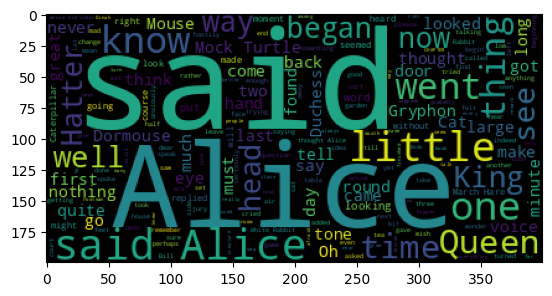

In [ ]:
# Install and import nltk for tokenizing words
!pip install nltk
import nltk
from nltk.tokenize import word_tokenize

# Import necessary libraries for generating word clouds where stop words are included by default.
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Download the Gutenberg corpus
nltk.download('gutenberg')

# Load the text of Alice's Adventures in Wonderland by Lewis Carroll in 1865
text = nltk.corpus.gutenberg.raw('carroll-alice.txt')

# Generate a Word Cloud from the text
wc = WordCloud().generate(text)

# Display the Word Cloud using Matplotlib
plt.imshow(wc)




### 2️⃣ 💊 <font color = 'red'> When you want to customize stop words, e.g., add some vocabulary to your graphic, you need to explicitly pass the WordCloud class which has a parameter called STOPWORDS where we can provide a set of stopwords and then write the following code lines.

    > WordCloud(stopwords = stopwords).generate(text)
    > stopwords.add('the')

**설명:** wordcloud 라이브러리를 사용하여 워드클라우드를 만들 경우 불용어는 제외되어 그래픽이 형성된다. 반면, 불용어를 지정해 놓는 경우가 있다. 이 경우는 불용어를 열거해 놓은 세트를 명시하고,  불용어 중에서 분석에 추가해 넣고 싶은 특정 어휘를 추가할 때이다. 아래 코드셀은 i) 불용어 중에 'the'만 추가로 워드클라우드 그래픽 만들 때 추가하고, ii) 나머지 불용어는 제외한다는 것을 작성한 것이다.  



[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


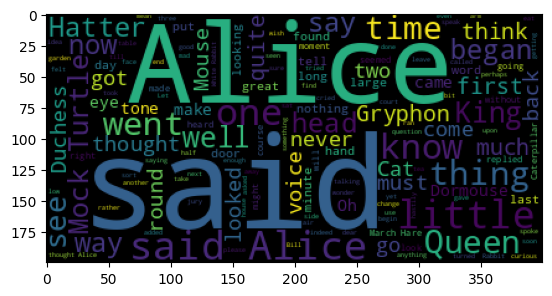

In [ ]:
# Install and import nltk for tokenizing words
!pip install nltk
import nltk
from nltk.tokenize import word_tokenize

# This imports the WordCloud class and a parameter called STOPWORDS set from the wordcloud library.
from wordcloud import WordCloud, STOPWORDS

# Download the Gutenberg corpus
nltk.download('gutenberg')

# Load the text of Alice's Adventures in Wonderland by Lewis Carroll in 1865
text = nltk.corpus.gutenberg.raw('carroll-alice.txt')

# Create a set of stopwords
stopwords = set(STOPWORDS) #This creates This line creates a set of stop words by converting STOPWORDS (which is a frozenset) into a regular set.

# Generate Word Cloud which includes 'the' but excludes other stopwords
wc1 = WordCloud(stopwords = stopwords).generate(text) #This generates the word cloud from the provided text, explicitly excluding the words which are present in the stopwords set. This code is prerequsite for the following code line (stopwords.add('the'))
stopwords.add('the') #Among excluded stop words, include 'the' in the analysis.

# Display the Word Cloud using Matplotlib
plt.imshow(wc1)

### 💊 <font color = 'red'> **3️⃣ For your information:**

In the following code cell, you can get a list of stopwords specified in the wordcloud library.

In [ ]:
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)
sorted(stopwords)

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',
 'ought',
 'our',
 

# **[ALERT]** The following script did not exclude quotes within quoted sentences. So, DO NOT USE the following script. I just decided to keep it for further reference.**